In [ ]:
#load data from seg_train
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import numpy as np

img_size = 128
batch_size = 32

datagen = ImageDataGenerator(rescale=1/255.,fill_mode='nearest')

data_generator = datagen.flow_from_directory('seg_train',target_size=(img_size, img_size),batch_size=batch_size,shuffle=True,class_mode='categorical')

# converting the generated images to numpy arrays
num_samples = data_generator.n
X = np.zeros((num_samples, img_size, img_size, 3))
Y = np.zeros((num_samples, len(data_generator.class_indices)))
for i in range(num_samples // batch_size):
    x_batch, y_batch = data_generator.next()
    X[i*batch_size:(i+1)*batch_size] = x_batch
    Y[i*batch_size:(i+1)*batch_size] = y_batch




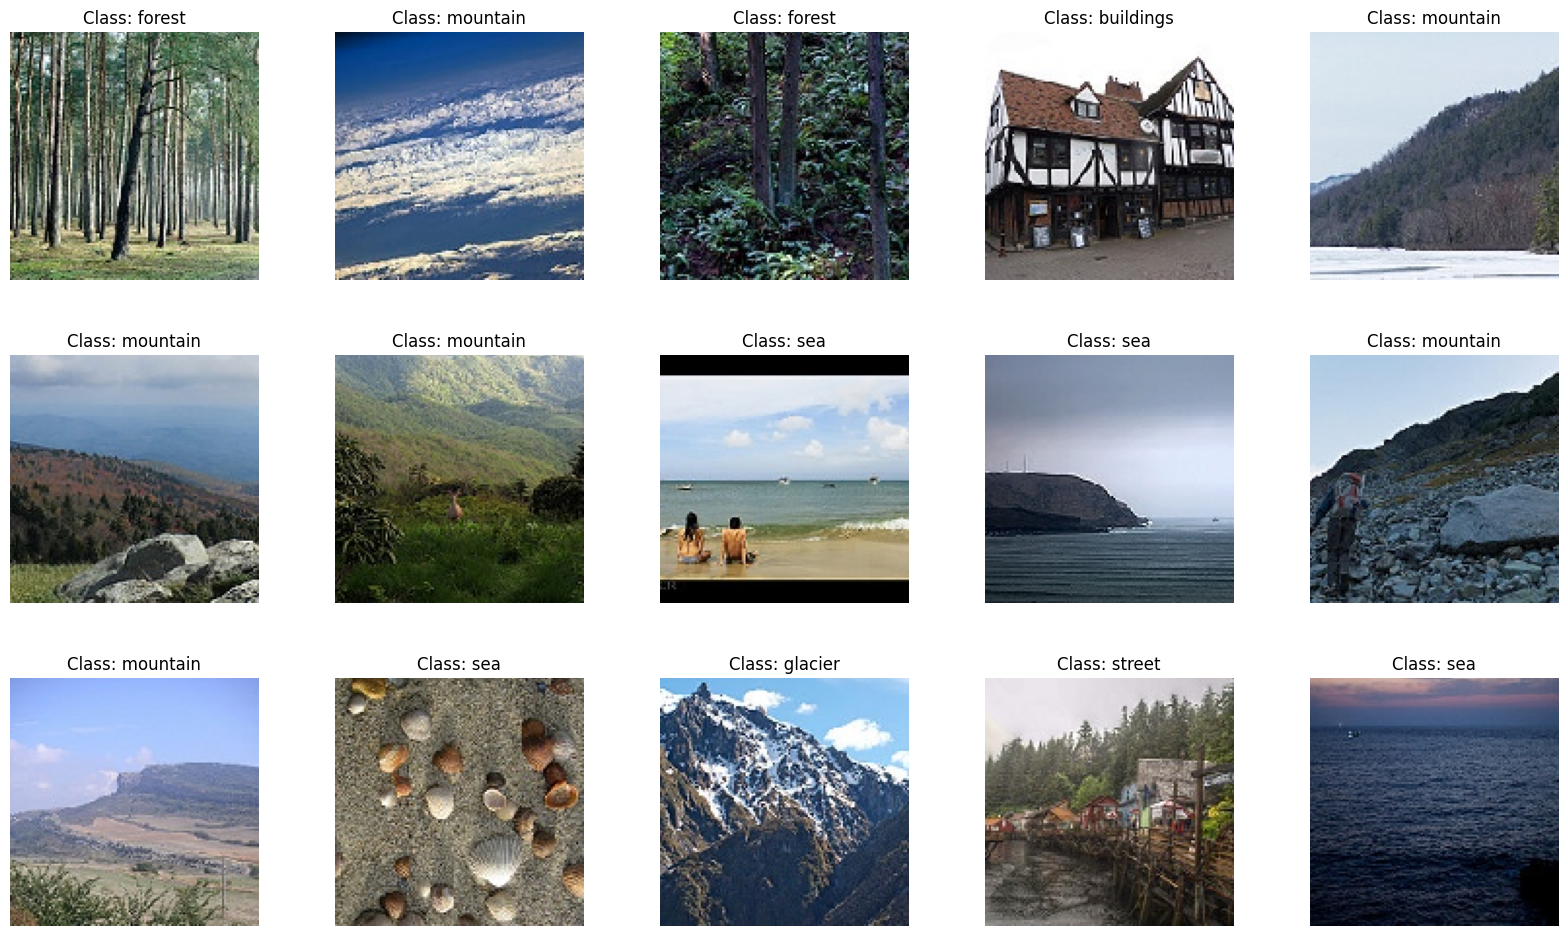

In [ ]:
import matplotlib.pyplot as plt
noter = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


samples = data_generator.__next__() 
images = samples[0]
target = samples[1]

plt.figure(figsize = (20,20))
for i in range(15):
    plt.subplot(5,5,i+1)
    plt.subplots_adjust(hspace=0.3,wspace=0.3)
    plt.imshow(images[i])
    plt.title(f"Class: {noter[int(np.argmax(target[i]))]}")
    plt.axis('off')

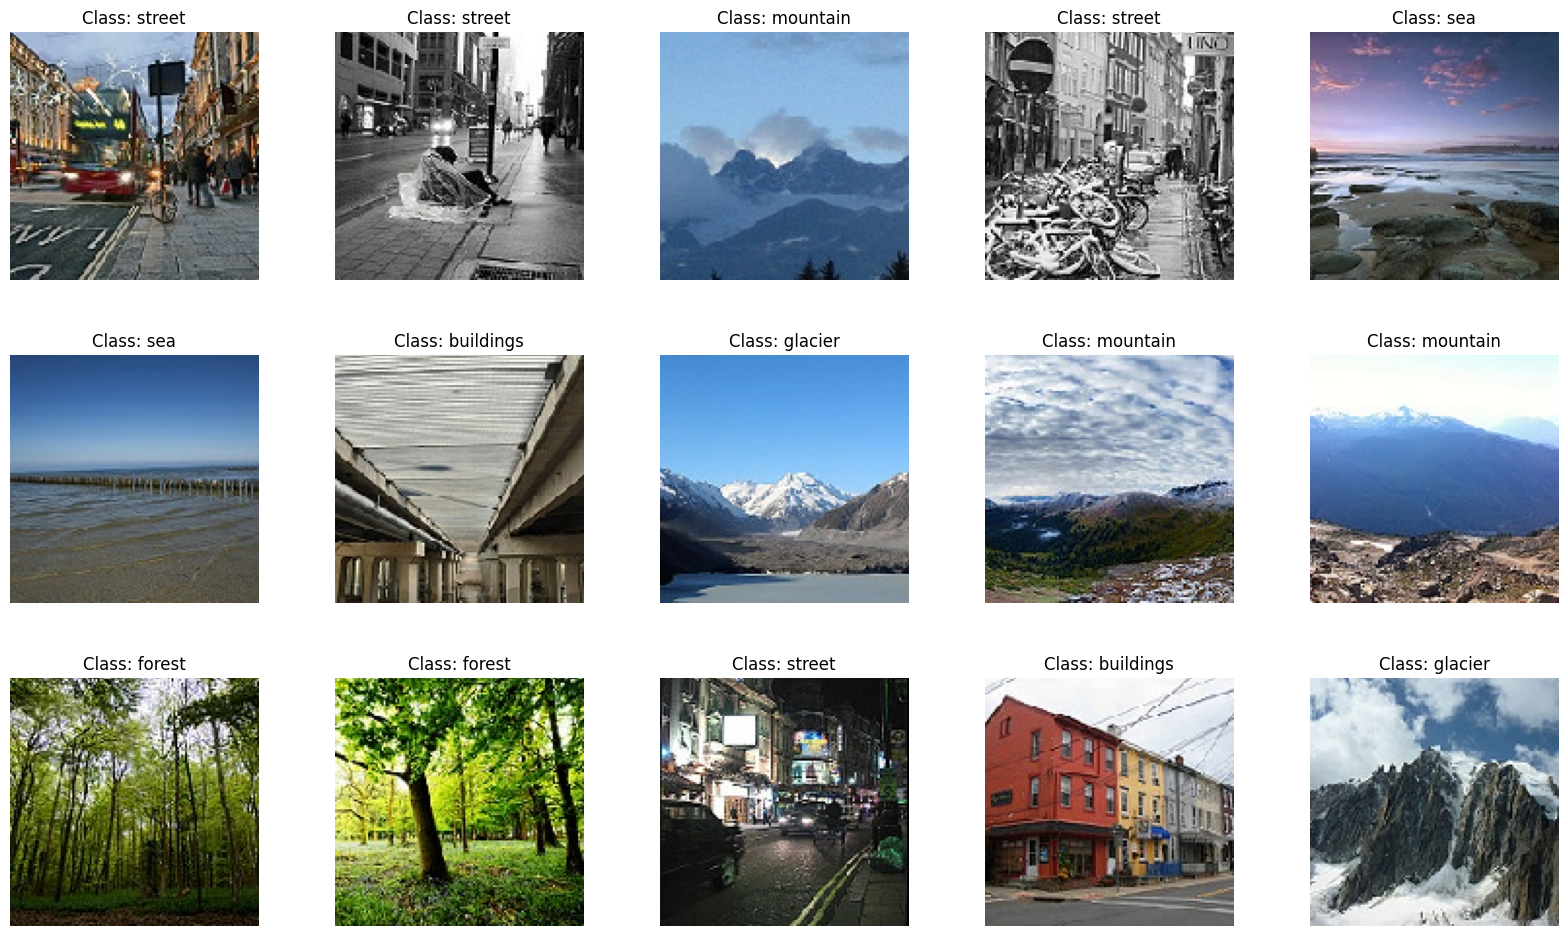

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import numpy as np


dataset = X
labels = Y

#downsample dataset and labels by 5
downsample=5
dataset = dataset[::downsample]
labels = labels[::downsample]


plt.figure(figsize = (20,20))
for i in range(15):
    plt.subplot(5,5,i+1)
    plt.subplots_adjust(hspace=0.3,wspace=0.3)
    plt.imshow(dataset[i])
    plt.title(f"Class: {noter[int(np.argmax(labels[i]))]}")
    plt.axis('off')


dataset, labels = shuffle(dataset, labels, random_state=0)

#split the dataset into train and test in 50 50 ratio
split=0.5
private_size= int(split * dataset.shape[0])
x_private = dataset[:private_size]
y_private = labels[:private_size]
x_public = dataset[private_size:]
y_public = labels[private_size:]

#convert to greyscale
x_private= 0.2989 * x_private[:,:,:,0] + 0.5870 * x_private[:,:,:,1] + 0.1140 * x_private[:,:,:,2]
x_public = 0.2989 * x_public[:,:,:,0] + 0.5870 * x_public[:,:,:,1] + 0.1140 * x_public[:,:,:,2]

#reshape to 4D
x_private = x_private.reshape(x_private.shape[0], img_size, img_size, 1)
x_public = x_public.reshape(x_public.shape[0], img_size, img_size, 1)



In [ ]:
kernel_sizer=15


# Define the CNN architecture
model = keras.Sequential(
    [
        layers.Input(shape=(img_size, img_size, 1)),
        layers.Conv2D(filters=1,kernel_size=kernel_sizer,strides=(1,1), use_bias=False, name='convolver'),
        layers.MaxPooling2D((2, 2)),
        layers.BatchNormalization(),
        layers.Conv2D(filters=16,kernel_size=kernel_sizer,strides=(1,1), use_bias=True, name='convolver2'),
        layers.MaxPooling2D((2, 2)),
        layers.BatchNormalization(),
        # layers.Conv2D(filters=32,kernel_size=kernel_sizer,strides=(1,1), use_bias=False, name='convolver3'),
        # layers.MaxPooling2D((2, 2)),
        # layers.BatchNormalization(),
        layers.Flatten(),
        # layers.Dense(256, activation='relu'),
        # layers.Dropout(0.3),
        layers.Dense(len(data_generator.class_indices), activation="softmax"),
    ]
)


# Train the CNN
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"],
)
model.fit(x_private, y_private, epochs=20, batch_size=64*2, validation_split=0.1)

# # Evaluate the CNN on the test data
# test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
# print("Test accuracy:", test_acc)

Epoch 1/20
10/10 [==============================] - 6s 58ms/step - loss: 2.0962 - accuracy: 0.3106 - val_loss: 1.8635 - val_accuracy: 0.1348
Epoch 2/20
10/10 [==============================] - 0s 14ms/step - loss: 1.5901 - accuracy: 0.4596 - val_loss: 1.6823 - val_accuracy: 0.3546
Epoch 3/20
10/10 [==============================] - 0s 14ms/step - loss: 1.1718 - accuracy: 0.5689 - val_loss: 1.6952 - val_accuracy: 0.3050
Epoch 4/20
10/10 [==============================] - 0s 14ms/step - loss: 0.8935 - accuracy: 0.6569 - val_loss: 1.6865 - val_accuracy: 0.2057
Epoch 5/20
10/10 [==============================] - 0s 14ms/step - loss: 0.6647 - accuracy: 0.7710 - val_loss: 1.6952 - val_accuracy: 0.1631
Epoch 6/20
10/10 [==============================] - 0s 15ms/step - loss: 0.5194 - accuracy: 0.8487 - val_loss: 1.6949 - val_accuracy: 0.1489
Epoch 7/20
10/10 [==============================] - 0s 14ms/step - loss: 0.4008 - accuracy: 0.8994 - val_loss: 1.7421 - val_accuracy: 0.1631
Epoch 8/20
10

In [ ]:
model.save('imagenet_cnn.h5')

1/1 [==============================] - 0s 76ms/step
(1, 114, 114, 1)


Text(0.5, 1.0, 'Output of Keras Convolution Layer')

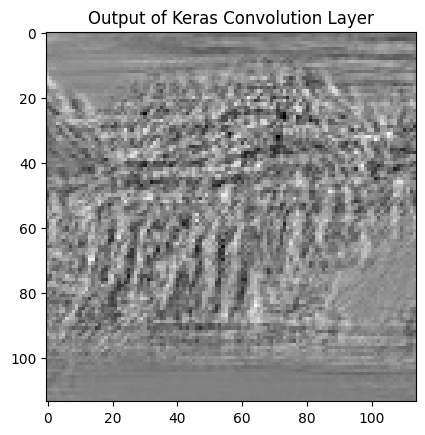

In [ ]:
layer_output=model.get_layer('convolver').output
intermediate_model=tf.keras.models.Model(inputs=model.input,outputs=layer_output)
inputer=x_private[0:1]
intermediate_prediction=intermediate_model.predict(inputer)
ref_image=intermediate_prediction[0,:,:,0]
print(intermediate_prediction.shape)
plt.imshow(ref_image, cmap='gray')
plt.title('Output of Keras Convolution Layer')

(114, 114)


Text(0.5, 1.0, 'Output of numpy convolution with kernel of Keras Convolution Layer')

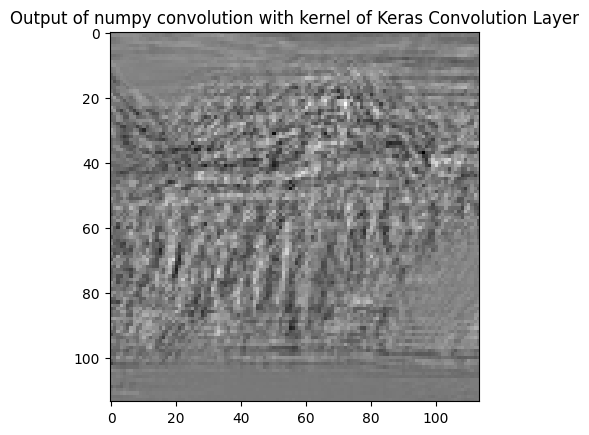

In [ ]:
import cv2
import numpy as np

first_layer_weights = model.layers[0].get_weights()[0]

kernel=first_layer_weights[:,:,0,0] #length x width x depth(channels)...I will remove depth also

original_kernel=np.copy(kernel)  #save a copy of the original kernel

image=x_private[0,:,:,0]


def convolve2D(image, kernel, padding=0, strides=1):
    # Cross Correlation
    kernel = np.flipud(np.fliplr(kernel))

    # Gather Shapes of Kernel + Image + Padding
    xKernShape = kernel.shape[0]
    yKernShape = kernel.shape[1]
    xImgShape = image.shape[0]
    yImgShape = image.shape[1]

    # Shape of Output Convolution
    xOutput = int(((xImgShape - xKernShape + 2 * padding) / strides) + 1)
    yOutput = int(((yImgShape - yKernShape + 2 * padding) / strides) + 1)
    output = np.zeros((xOutput, yOutput))

    # Apply Equal Padding to All Sides
    if padding != 0:
        imagePadded = np.zeros((image.shape[0] + padding*2, image.shape[1] + padding*2))
        imagePadded[int(padding):int(-1 * padding), int(padding):int(-1 * padding)] = image
        print(imagePadded)
    else:
        imagePadded = image

    # Iterate through image
    for y in range(image.shape[1]):
        # Exit Convolution
        if y > image.shape[1] - yKernShape:
            break
        # Only Convolve if y has gone down by the specified Strides
        if y % strides == 0:
            for x in range(image.shape[0]):
                # Go to next row once kernel is out of bounds
                if x > image.shape[0] - xKernShape:
                    break
                try:
                    # Only Convolve if x has moved by the specified Strides
                    if x % strides == 0:
                        output[x, y] = (kernel * imagePadded[x: x + xKernShape, y: y + yKernShape]).sum()
                except:
                    break

    return output

result_normal = convolve2D(image, kernel)


print(result_normal.shape)
plt.imshow(result_normal, cmap='gray')
plt.title('Output of numpy convolution with kernel of Keras Convolution Layer')

Text(0.5, 1.0, 'Input image')

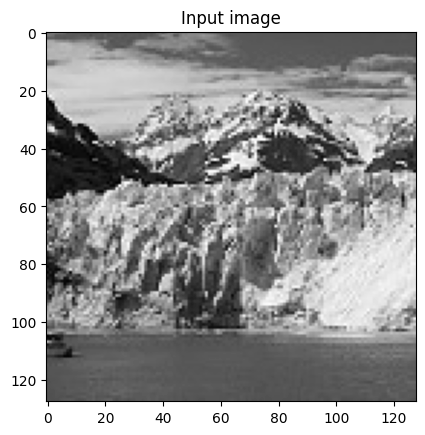

In [ ]:
plt.imshow(image, cmap='gray')
plt.title('Input image')

Text(0.5, 1.0, 'Output of numpy convolution with kernel of Keras Convolution Layer after Arnold map')

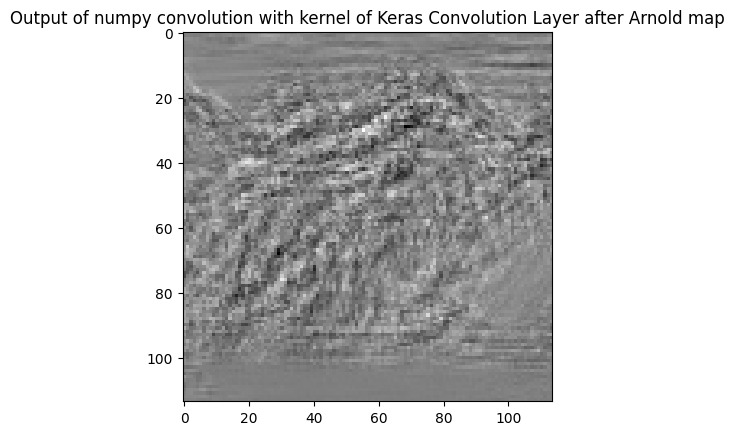

In [ ]:
num_iterations = 10 # number of Arnold map iterations

# #-----------------Arnold-Algo-1------------------------------------------

# # Permute indices of conv_filter using Arnold's chaotic map
# s = 3  # size of kernel

# def arnold_map(x, y, s=1):
#     x_prime = (x + y) % s
#     y_prime = (x + 2*y) % s
#     return x_prime, y_prime


# for i in range(num_iterations):
#     new_kernel = np.zeros((s, s))
#     for x in range(s):
#         for y in range(s):
#             x_prime, y_prime = arnold_map(x, y, s)
#             new_kernel[x_prime, y_prime] = kernel[x, y]

# #-------------------------------------------------------------------------



#-----------------Arnold-Algo-2-------------------------------------------

def arnold_map(matrix, k):
    """
    Applies k iterations of Arnold's chaotic map to a numpy matrix.
    """
    n, m = matrix.shape
    permuted_matrix = np.zeros_like(matrix)
    for i in range(k):
        for x in range(n):
            for y in range(m):
                x_prime = (x + y) % n
                y_prime = (2 * x + y) % m
                permuted_matrix[x_prime, y_prime] = matrix[x, y]
        matrix = permuted_matrix.copy()
    return permuted_matrix

new_kernel = arnold_map(kernel, num_iterations)
#-------------------------------------------------------------------------


destroyed_kernel = new_kernel.copy()

destroyed_result= convolve2D(image, destroyed_kernel)
plt.imshow(destroyed_result, cmap='gray')
plt.title('Output of numpy convolution with kernel of Keras Convolution Layer after Arnold map')

Text(0.5, 1.0, 'Output of Decrypted Convolution Layer')

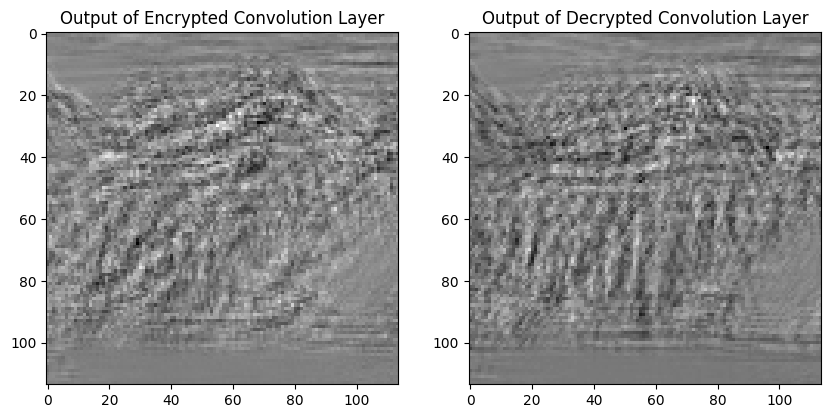

In [ ]:
#compare destroyed result with result_normal
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(destroyed_result, cmap='gray')
plt.title('Output of Encrypted Convolution Layer')
plt.subplot(1,2,2)
plt.imshow(result_normal, cmap='gray')
plt.title('Output of Decrypted Convolution Layer')

In [ ]:
#Ca

In [ ]:
from tensorflow.keras.layers import Layer, Conv2D
from tensorflow.keras import backend as K

# Define the CNN architecture
from keras import regularizers

dummy_model = keras.Sequential(
    [
        layers.Input(shape=(img_size, img_size, 1)),
        layers.Conv2D(filters=1,kernel_size=kernel_sizer,strides=(1,1), use_bias=False, name='convolver'),
        layers.MaxPooling2D((2, 2)),
        layers.BatchNormalization(),
        layers.Conv2D(filters=16,kernel_size=kernel_sizer,strides=(1,1), use_bias=True, name='convolver2'),
        layers.MaxPooling2D((2, 2)),
        layers.BatchNormalization(),
        # layers.Conv2D(filters=32,kernel_size=kernel_sizer,strides=(1,1), use_bias=False, name='convolver3'),
        # layers.MaxPooling2D((2, 2)),
        # layers.BatchNormalization(),
        layers.Flatten(),
        # layers.Dense(256, activation='relu'),
        # layers.Dropout(0.3),
        layers.Dense(len(data_generator.class_indices), activation="softmax"),
    ]
)

# Train the CNN
dummy_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"],
)
history_dummy=dummy_model.fit(x_public, y_public, epochs=20, batch_size=64*2, validation_split=0.1)


Epoch 1/20
10/10 [==============================] - 1s 77ms/step - loss: 1.9672 - accuracy: 0.3500 - val_loss: 1.5811 - val_accuracy: 0.3121
Epoch 2/20
10/10 [==============================] - 0s 14ms/step - loss: 1.2302 - accuracy: 0.5519 - val_loss: 1.6089 - val_accuracy: 0.4610
Epoch 3/20
10/10 [==============================] - 0s 13ms/step - loss: 0.8850 - accuracy: 0.6714 - val_loss: 1.5882 - val_accuracy: 0.4539
Epoch 4/20
10/10 [==============================] - 0s 14ms/step - loss: 0.6841 - accuracy: 0.7569 - val_loss: 1.5750 - val_accuracy: 0.4752
Epoch 5/20
10/10 [==============================] - 0s 15ms/step - loss: 0.5126 - accuracy: 0.8195 - val_loss: 1.6078 - val_accuracy: 0.4326
Epoch 6/20
10/10 [==============================] - 0s 16ms/step - loss: 0.3482 - accuracy: 0.9066 - val_loss: 1.5848 - val_accuracy: 0.4184
Epoch 7/20
10/10 [==============================] - 0s 16ms/step - loss: 0.2869 - accuracy: 0.9319 - val_loss: 1.5961 - val_accuracy: 0.3191
Epoch 8/20
10

In [ ]:
training_loss_dummy=history_dummy.history['loss']
val_loss_dummy=history_dummy.history['val_loss']
training_acc_dummy=history_dummy.history['accuracy']
val_acc_dummy=history_dummy.history['val_accuracy']

In [ ]:
from tensorflow.keras.layers import Layer, Conv2D
from tensorflow.keras import backend as K


# count the number of elements of two matrices M and N, such that difference is less than 0.01
def count_equal(M,N,threshold=0.000001):
    count=0
    for i in range(len(M)):
        for j in range(len(M)):
            if abs(M[i][j]-N[i][j])<threshold:
                count=count+1
    return count



Kernel_record=[]
History_acc_record=[]
History_loss_record=[]
History_valloss_record=[]
History_valacc_record=[]
equalization_record=[]  # intended for keeping recording whether permutation matches the original kernel or not
threshold=0.01           # thredhold for equalization
trys=16*3
random_trys=80


for trying in range(trys):
    if trying==trys-1:
        for sub_trying in range(random_trys):

            m, n = destroyed_kernel.shape

            # Reshape the matrix into a 1D array
            matrix_1d = destroyed_kernel.reshape(-1)

            # Shuffle the 1D array randomly
            np.random.shuffle(matrix_1d)

            # Reshape the shuffled 1D array back to the original shape
            destroyed_kernel_permuted= matrix_1d.reshape(m, n)

            
            same=count_equal(destroyed_kernel_permuted,original_kernel)
            num_enteries=original_kernel.shape[0]*original_kernel.shape[1]
            match_ratio=same/num_enteries

            equalization_record.append(match_ratio)
            
            new_layer=layers.Conv2D(filters=1, kernel_size=kernel_sizer, strides=(1, 1),name='modified',
                            kernel_initializer=keras.initializers.Constant(value=destroyed_kernel_permuted),
                            trainable=False)

            prev_model=dummy_model

            #orchestrating a new model, same as dummy model, except its first convolution layer is replaced with permuted Arnold encrypted kernel layer
            inputs = layers.Input(shape=(img_size, img_size, 1),name='inner')
            x = inputs
            x= new_layer(x)
            for layer in prev_model.layers[1:]:
                x = prev_model.get_layer(layer.name)(x)
            #   print(layer.name, layer.trainable)

            mod_model=keras.Model(inputs, x)
            # Train the CNN
            mod_model.compile(
                optimizer=keras.optimizers.Adam(learning_rate=1e-5),
                loss=keras.losses.CategoricalCrossentropy(from_logits=False),
                metrics=["accuracy"],
            )

            history=mod_model.fit(x_public, y_public, epochs=10, batch_size=64*2, validation_split=0.1,verbose=0)
            training_loss_mod=history.history['loss']
            val_loss_mod=history.history['val_loss']
            training_acc_mod=history.history['accuracy']
            val_acc_mod=history.history['val_accuracy']

            total_training_loss_mod=training_loss_dummy+training_loss_mod
            total_val_loss_mod=val_loss_dummy+val_loss_mod
            total_training_acc_mod=training_acc_dummy+training_acc_mod
            total_val_acc_mod=val_acc_dummy+val_acc_mod


            History_acc_record.append(total_training_acc_mod)
            History_loss_record.append(total_training_loss_mod)
            History_valloss_record.append(total_val_loss_mod)
            History_valacc_record.append(total_val_acc_mod)


            #save the kernel
            Kernel_record.append(destroyed_kernel_permuted)


    else:
        ref_destroyed_kernel = np.copy(original_kernel)

        n = (4*trying+1)  # Number of entries to permute

        m=len(ref_destroyed_kernel) # Size of matrix

        # Flatten the matrix to a 1D array
        flat_matrix = ref_destroyed_kernel.flatten()

        # Randomly permute n elements in the flat matrix
        perm_indices = np.random.choice(m**2, size=n, replace=False)
        flat_matrix[perm_indices] = np.random.permutation(flat_matrix[perm_indices])

        # Reshape the flat matrix back to the original shape
        permuted_matrix = flat_matrix.reshape(m, m)

        destroyed_kernel_permuted= permuted_matrix 

        same=count_equal(destroyed_kernel_permuted,original_kernel)
        num_enteries=original_kernel.shape[0]*original_kernel.shape[1]
        match_ratio=same/num_enteries

        if match_ratio>0.8:
            subtrys=20
        else:
            subtrys=5

        for sub_trying in range(subtrys):
            equalization_record.append(match_ratio)

            
            new_layer=layers.Conv2D(filters=1, kernel_size=kernel_sizer, strides=(1, 1),name='modified',
                            kernel_initializer=keras.initializers.Constant(value=destroyed_kernel_permuted),
                            trainable=False)

            prev_model=dummy_model

            #orchestrating a new model, same as dummy model, except its first convolution layer is replaced with permuted Arnold encrypted kernel layer
            inputs = layers.Input(shape=(img_size, img_size, 1),name='inner')
            x = inputs
            x= new_layer(x)
            for layer in prev_model.layers[1:]:
                x = prev_model.get_layer(layer.name)(x)
            #   print(layer.name, layer.trainable)

            mod_model=keras.Model(inputs, x)
            # Train the CNN
            mod_model.compile(
                optimizer=keras.optimizers.Adam(learning_rate=1e-5),
                loss=keras.losses.CategoricalCrossentropy(from_logits=False),
                metrics=["accuracy"],
            )

            history=mod_model.fit(x_public, y_public, epochs=10, batch_size=64*2, validation_split=0.1,verbose=0)
            training_loss_mod=history.history['loss']
            val_loss_mod=history.history['val_loss']
            training_acc_mod=history.history['accuracy']
            val_acc_mod=history.history['val_accuracy']

            total_training_loss_mod=training_loss_dummy+training_loss_mod
            total_val_loss_mod=val_loss_dummy+val_loss_mod
            total_training_acc_mod=training_acc_dummy+training_acc_mod
            total_val_acc_mod=val_acc_dummy+val_acc_mod


            History_acc_record.append(total_training_acc_mod)
            History_loss_record.append(total_training_loss_mod)
            History_valloss_record.append(total_val_loss_mod)
            History_valacc_record.append(total_val_acc_mod)


            #save the kernel
            Kernel_record.append(destroyed_kernel_permuted)




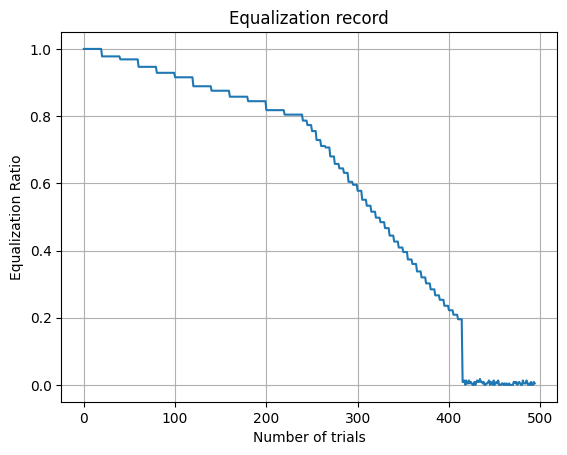

In [ ]:
#plot equalization record
plt.plot(equalization_record)
plt.title('Equalization record')
plt.xlabel('Number of trials')
plt.ylabel('Equalization Ratio')
plt.grid()

C:\Users\dianu\AppData\Local\Temp\ipykernel_11108\641979804.py:14: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


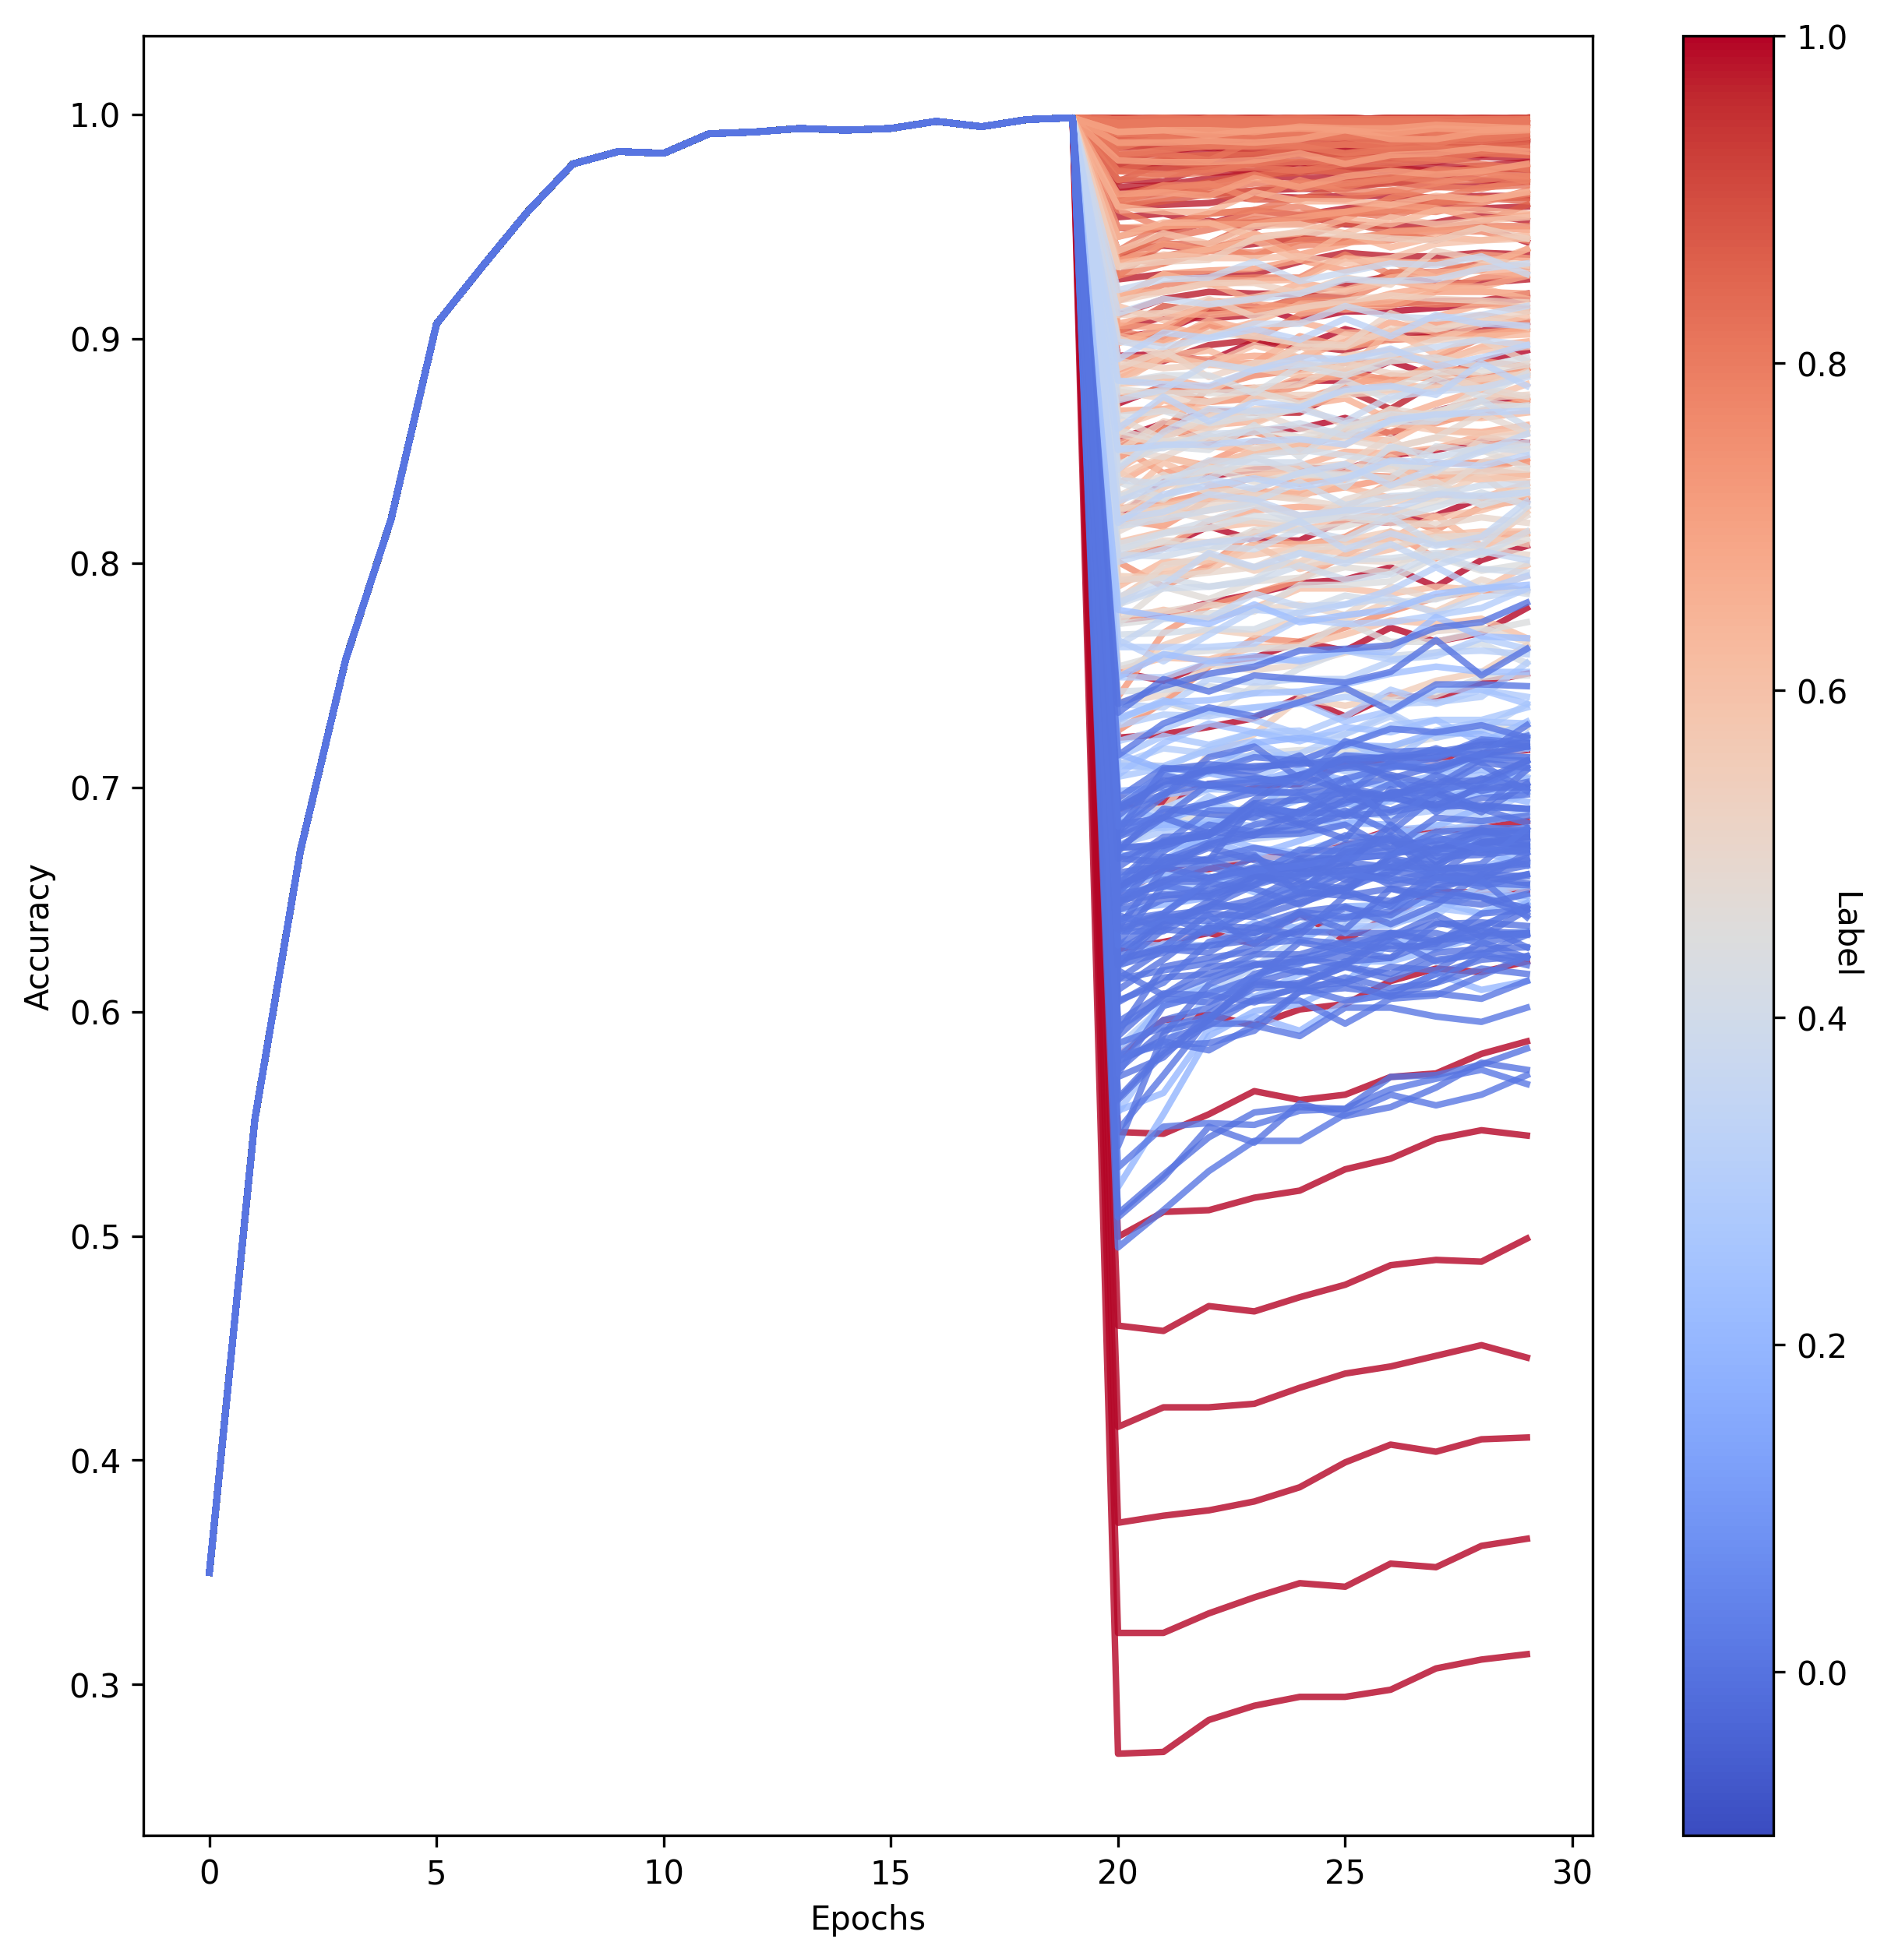

In [ ]:
# Plotting
fig, ax = plt.subplots(figsize=(10, 10),dpi=300)

cmap = plt.cm.get_cmap('coolwarm')  # Colormap to use
normalize = plt.Normalize(vmin=min(equalization_record)-0.1, vmax=1)  # Normalize values to colormap

for i in range(len(History_acc_record)):
    color = cmap(normalize(equalization_record[i]))  # Get color based on label value
    ax.plot(History_acc_record[i], color=color, linewidth=2, alpha=0.8)

# Colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=normalize)
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.ax.set_ylabel('Label', rotation=270)

# Labels and title
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')

plt.show()


C:\Users\dianu\AppData\Local\Temp\ipykernel_11108\549718615.py:14: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


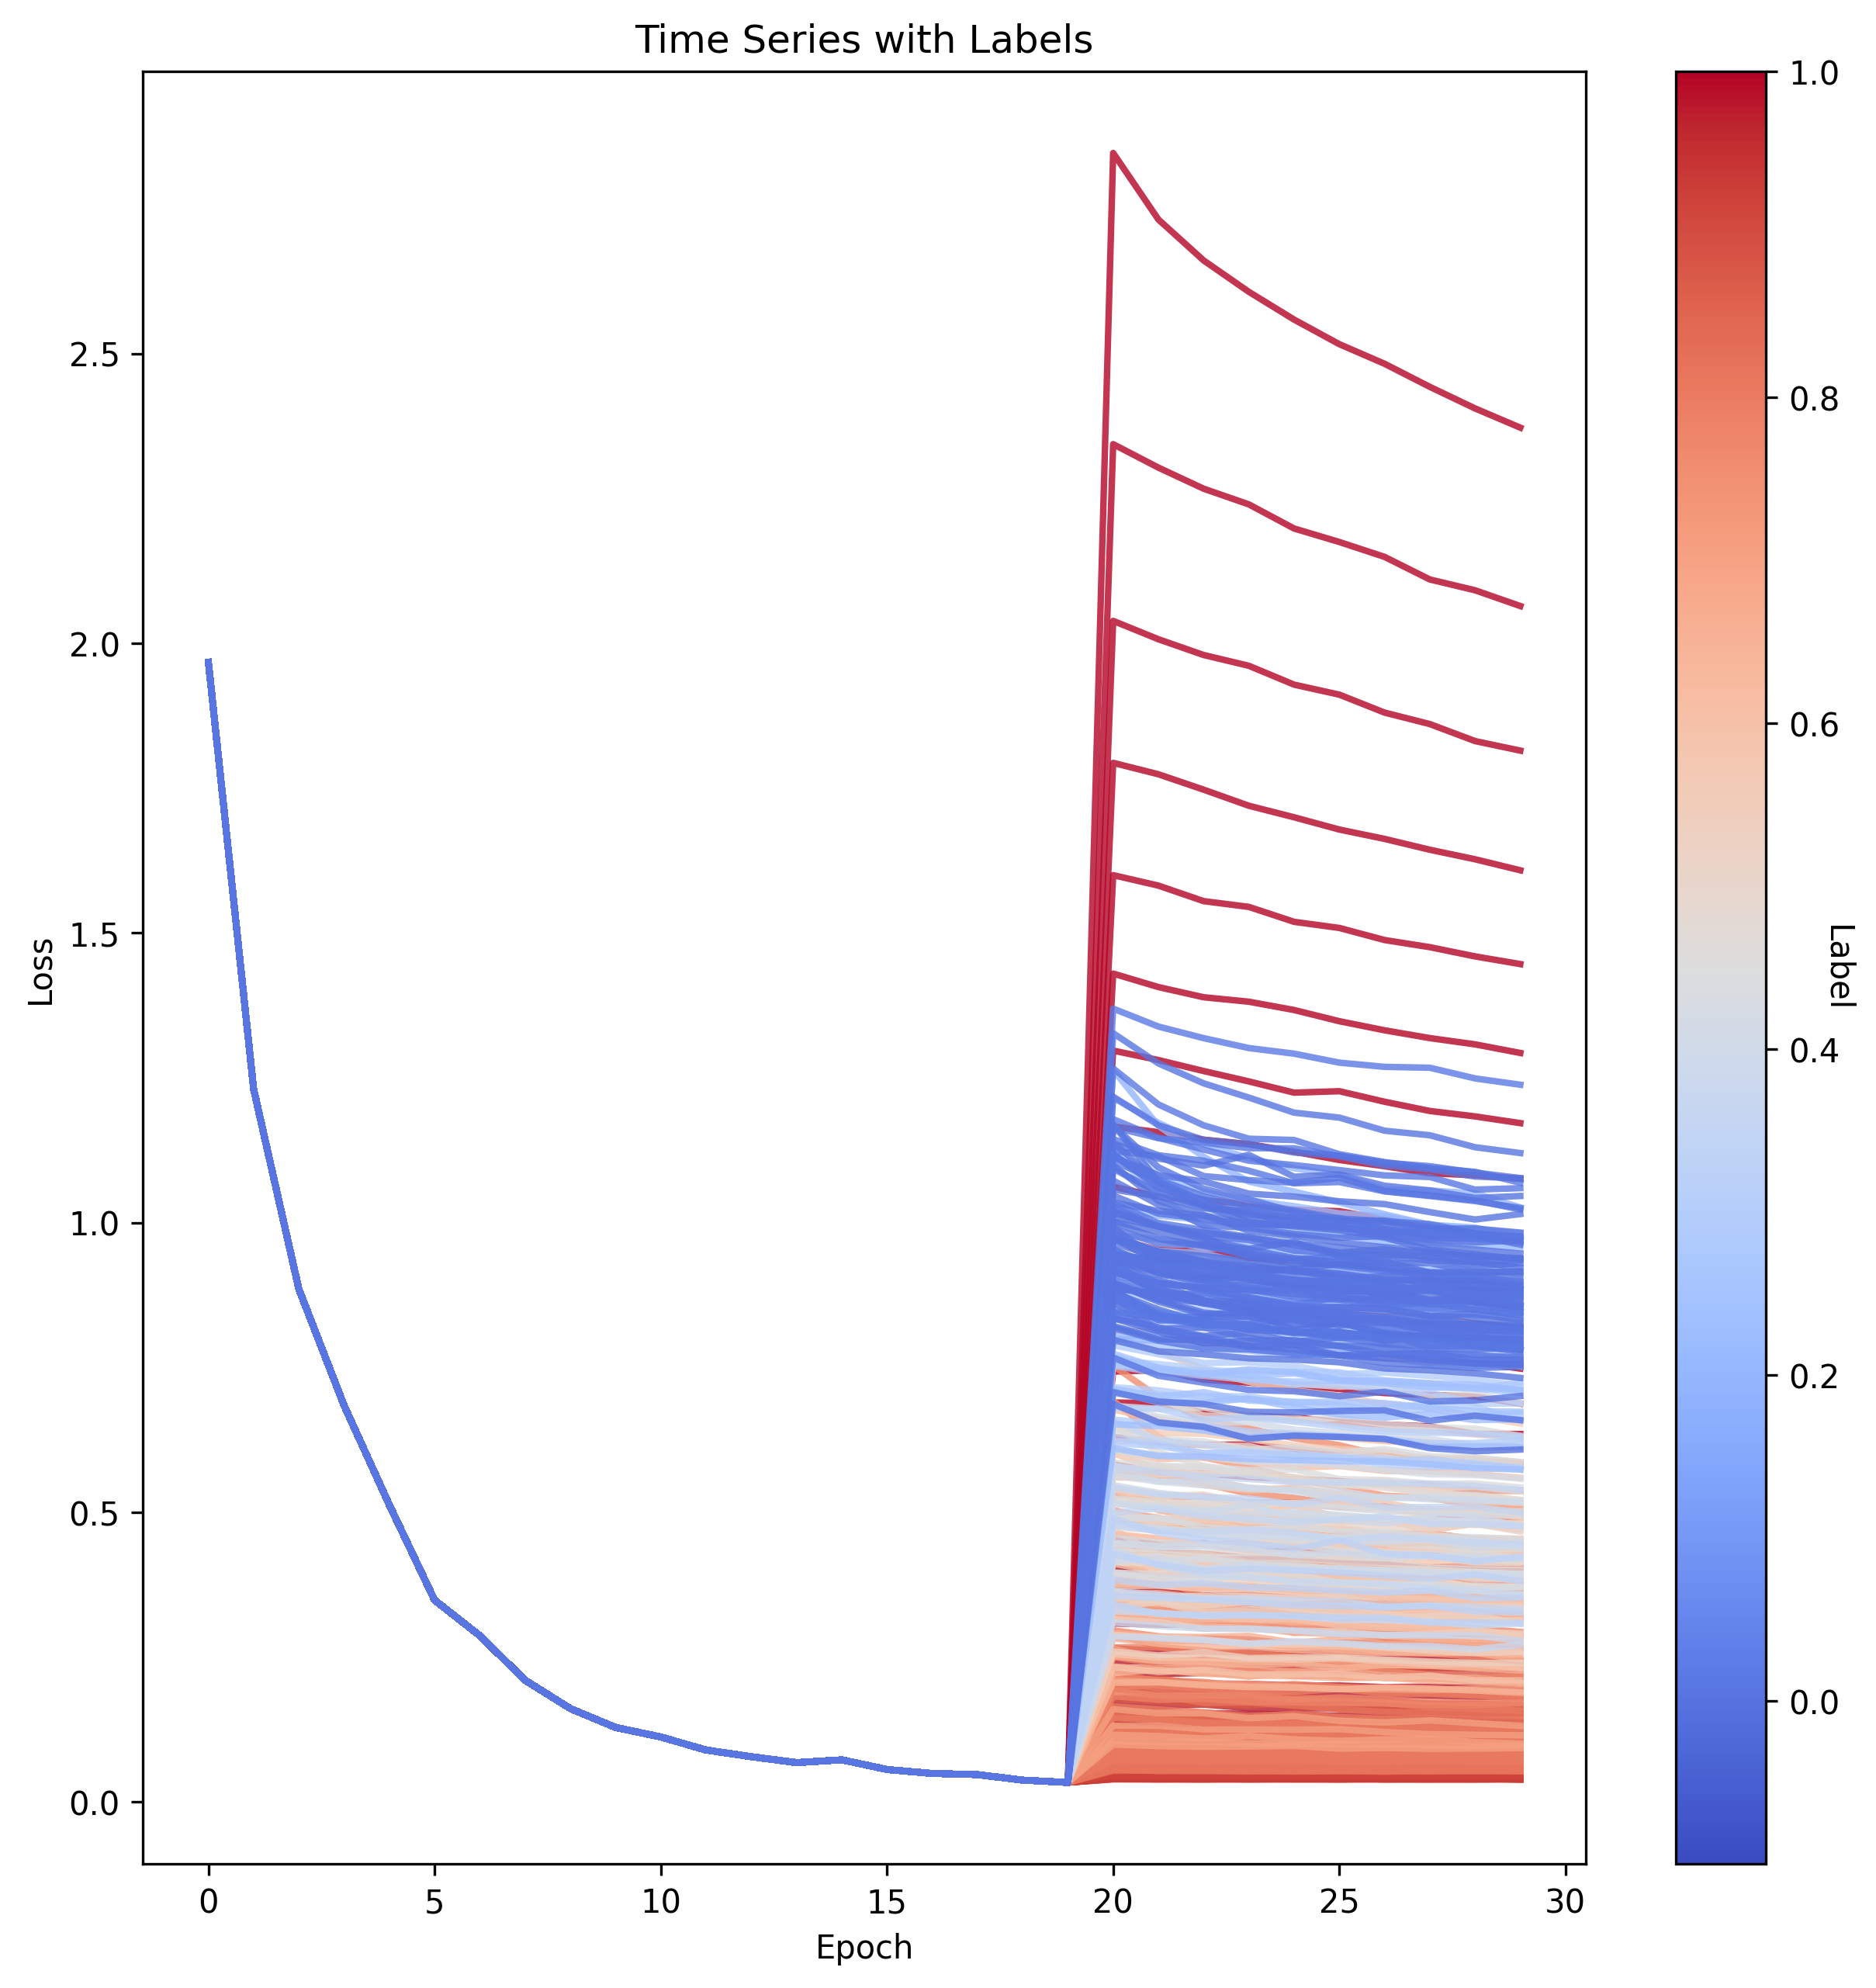

In [ ]:
# Plotting
fig, ax = plt.subplots(figsize=(10, 10),dpi=300)

cmap = plt.cm.get_cmap('coolwarm')  # Colormap to use
normalize = plt.Normalize(vmin=min(equalization_record)-0.1, vmax=1)  # Normalize values to colormap

for i in range(len(History_loss_record)):
    color = cmap(normalize(equalization_record[i]))  # Get color based on label value
    ax.plot(History_loss_record[i], color=color, linewidth=2, alpha=0.8)

# Colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=normalize)
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.ax.set_ylabel('Label', rotation=270)

# Labels and title
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Time Series with Labels')

plt.show()


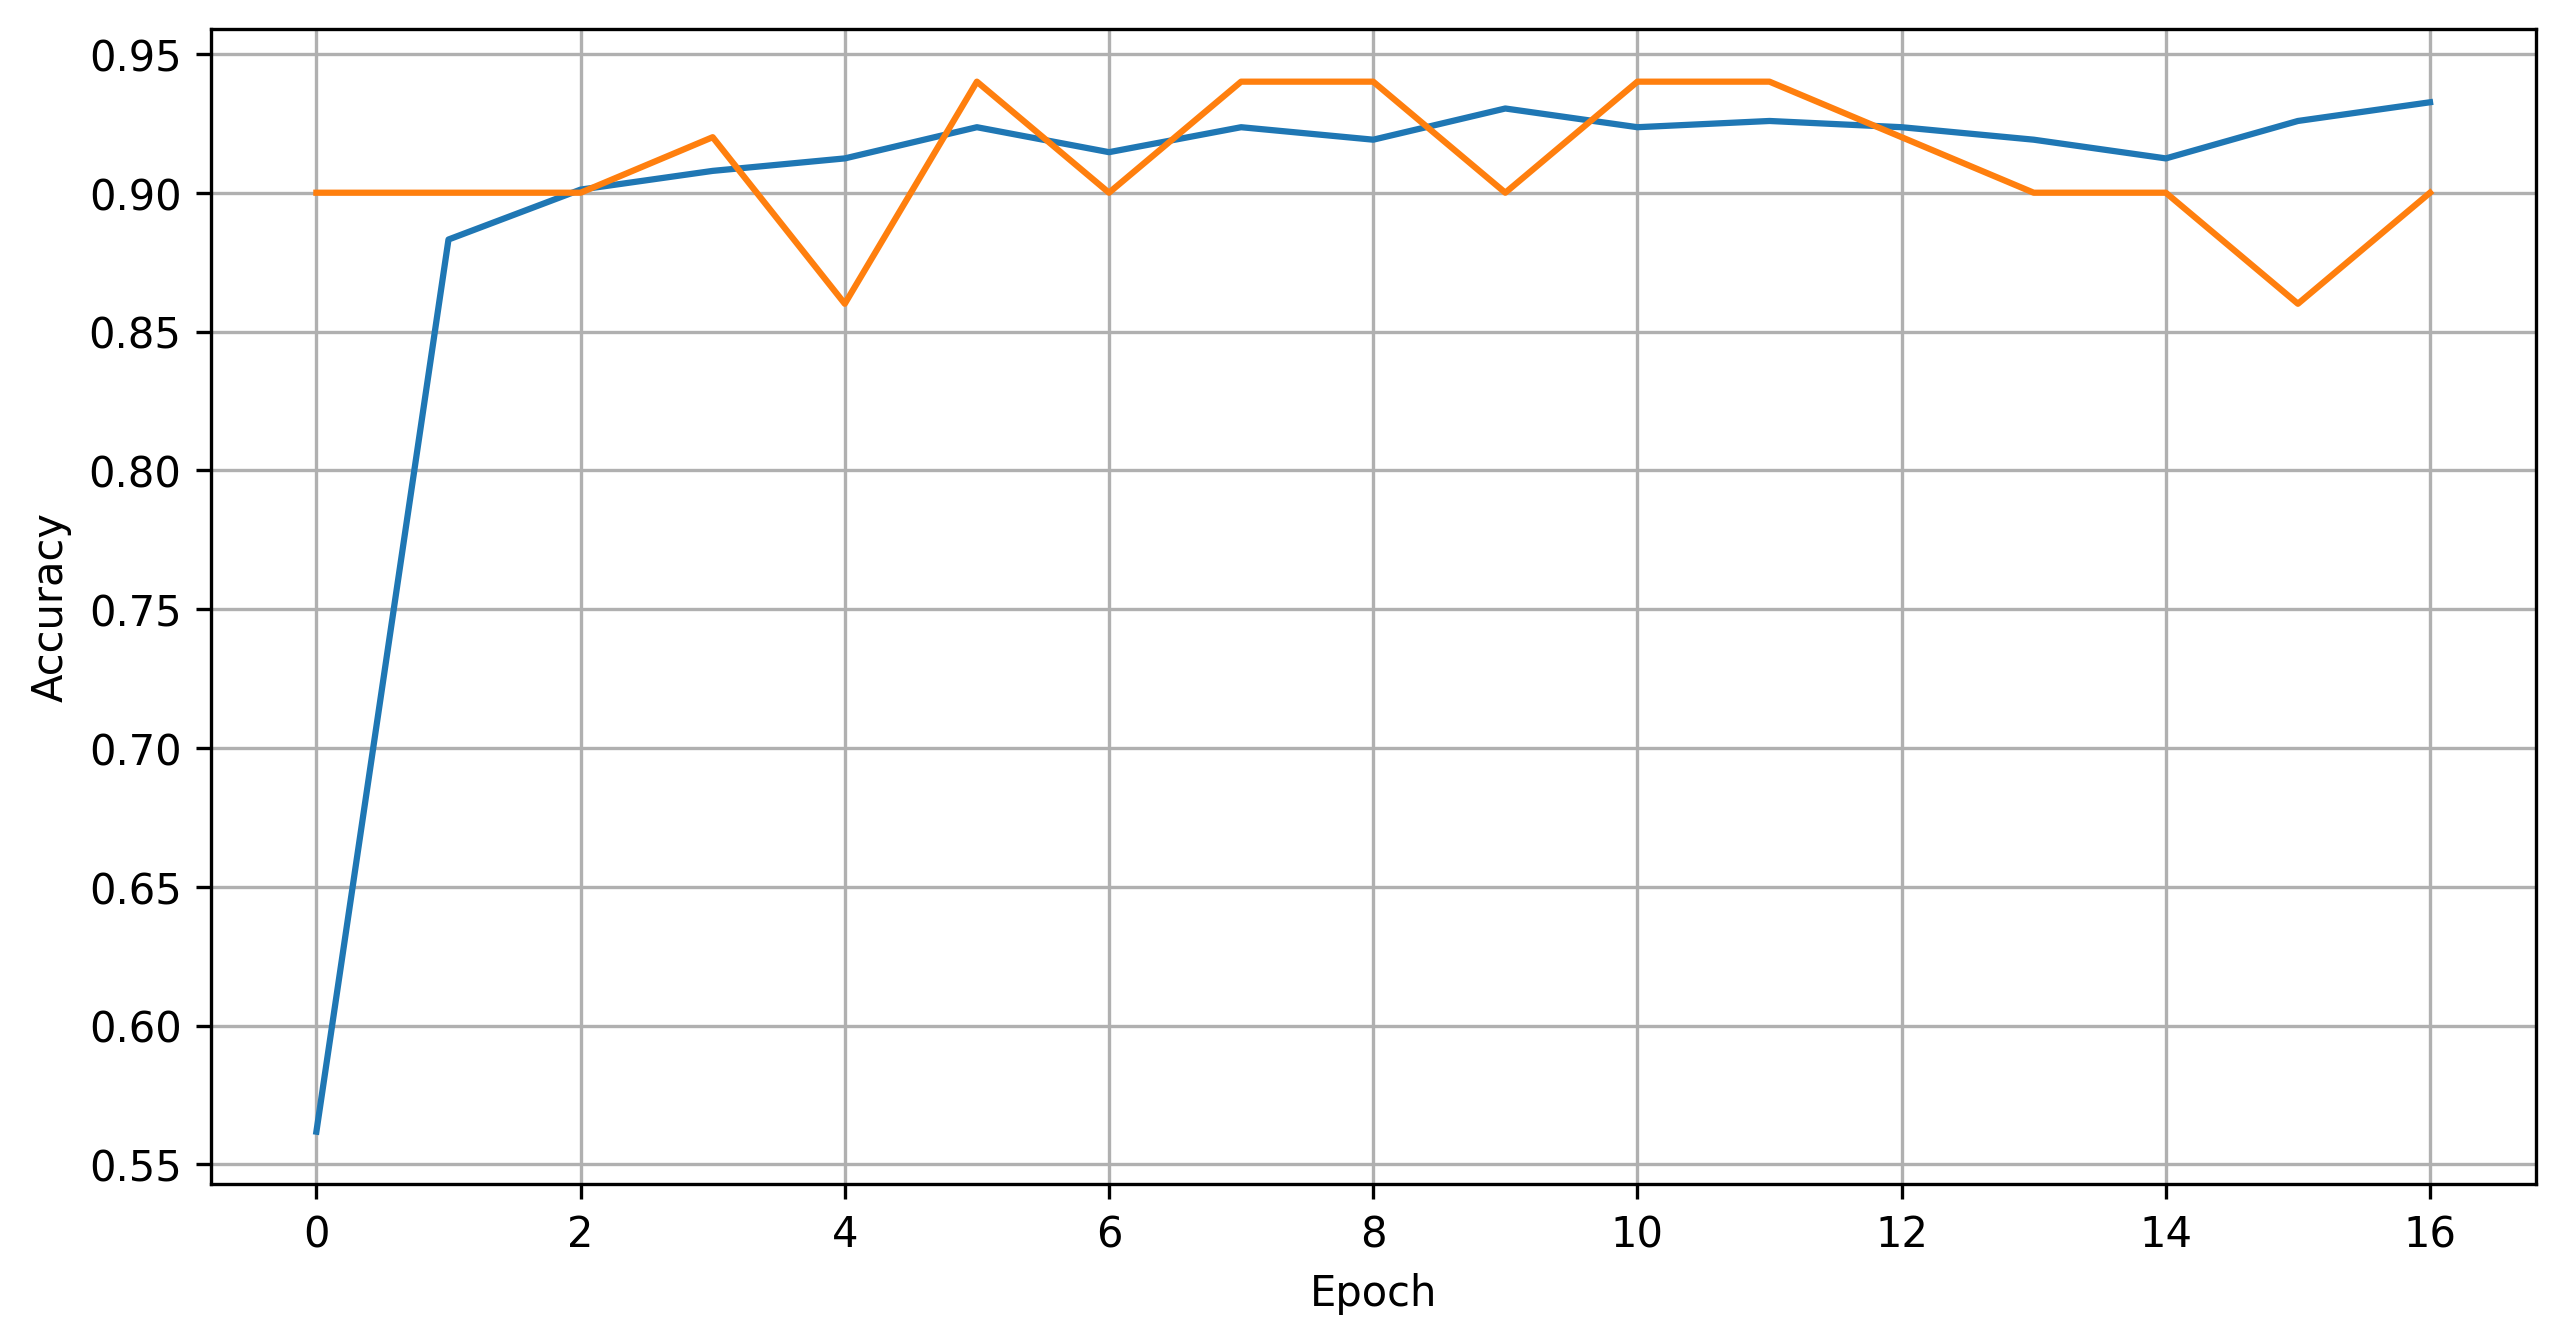

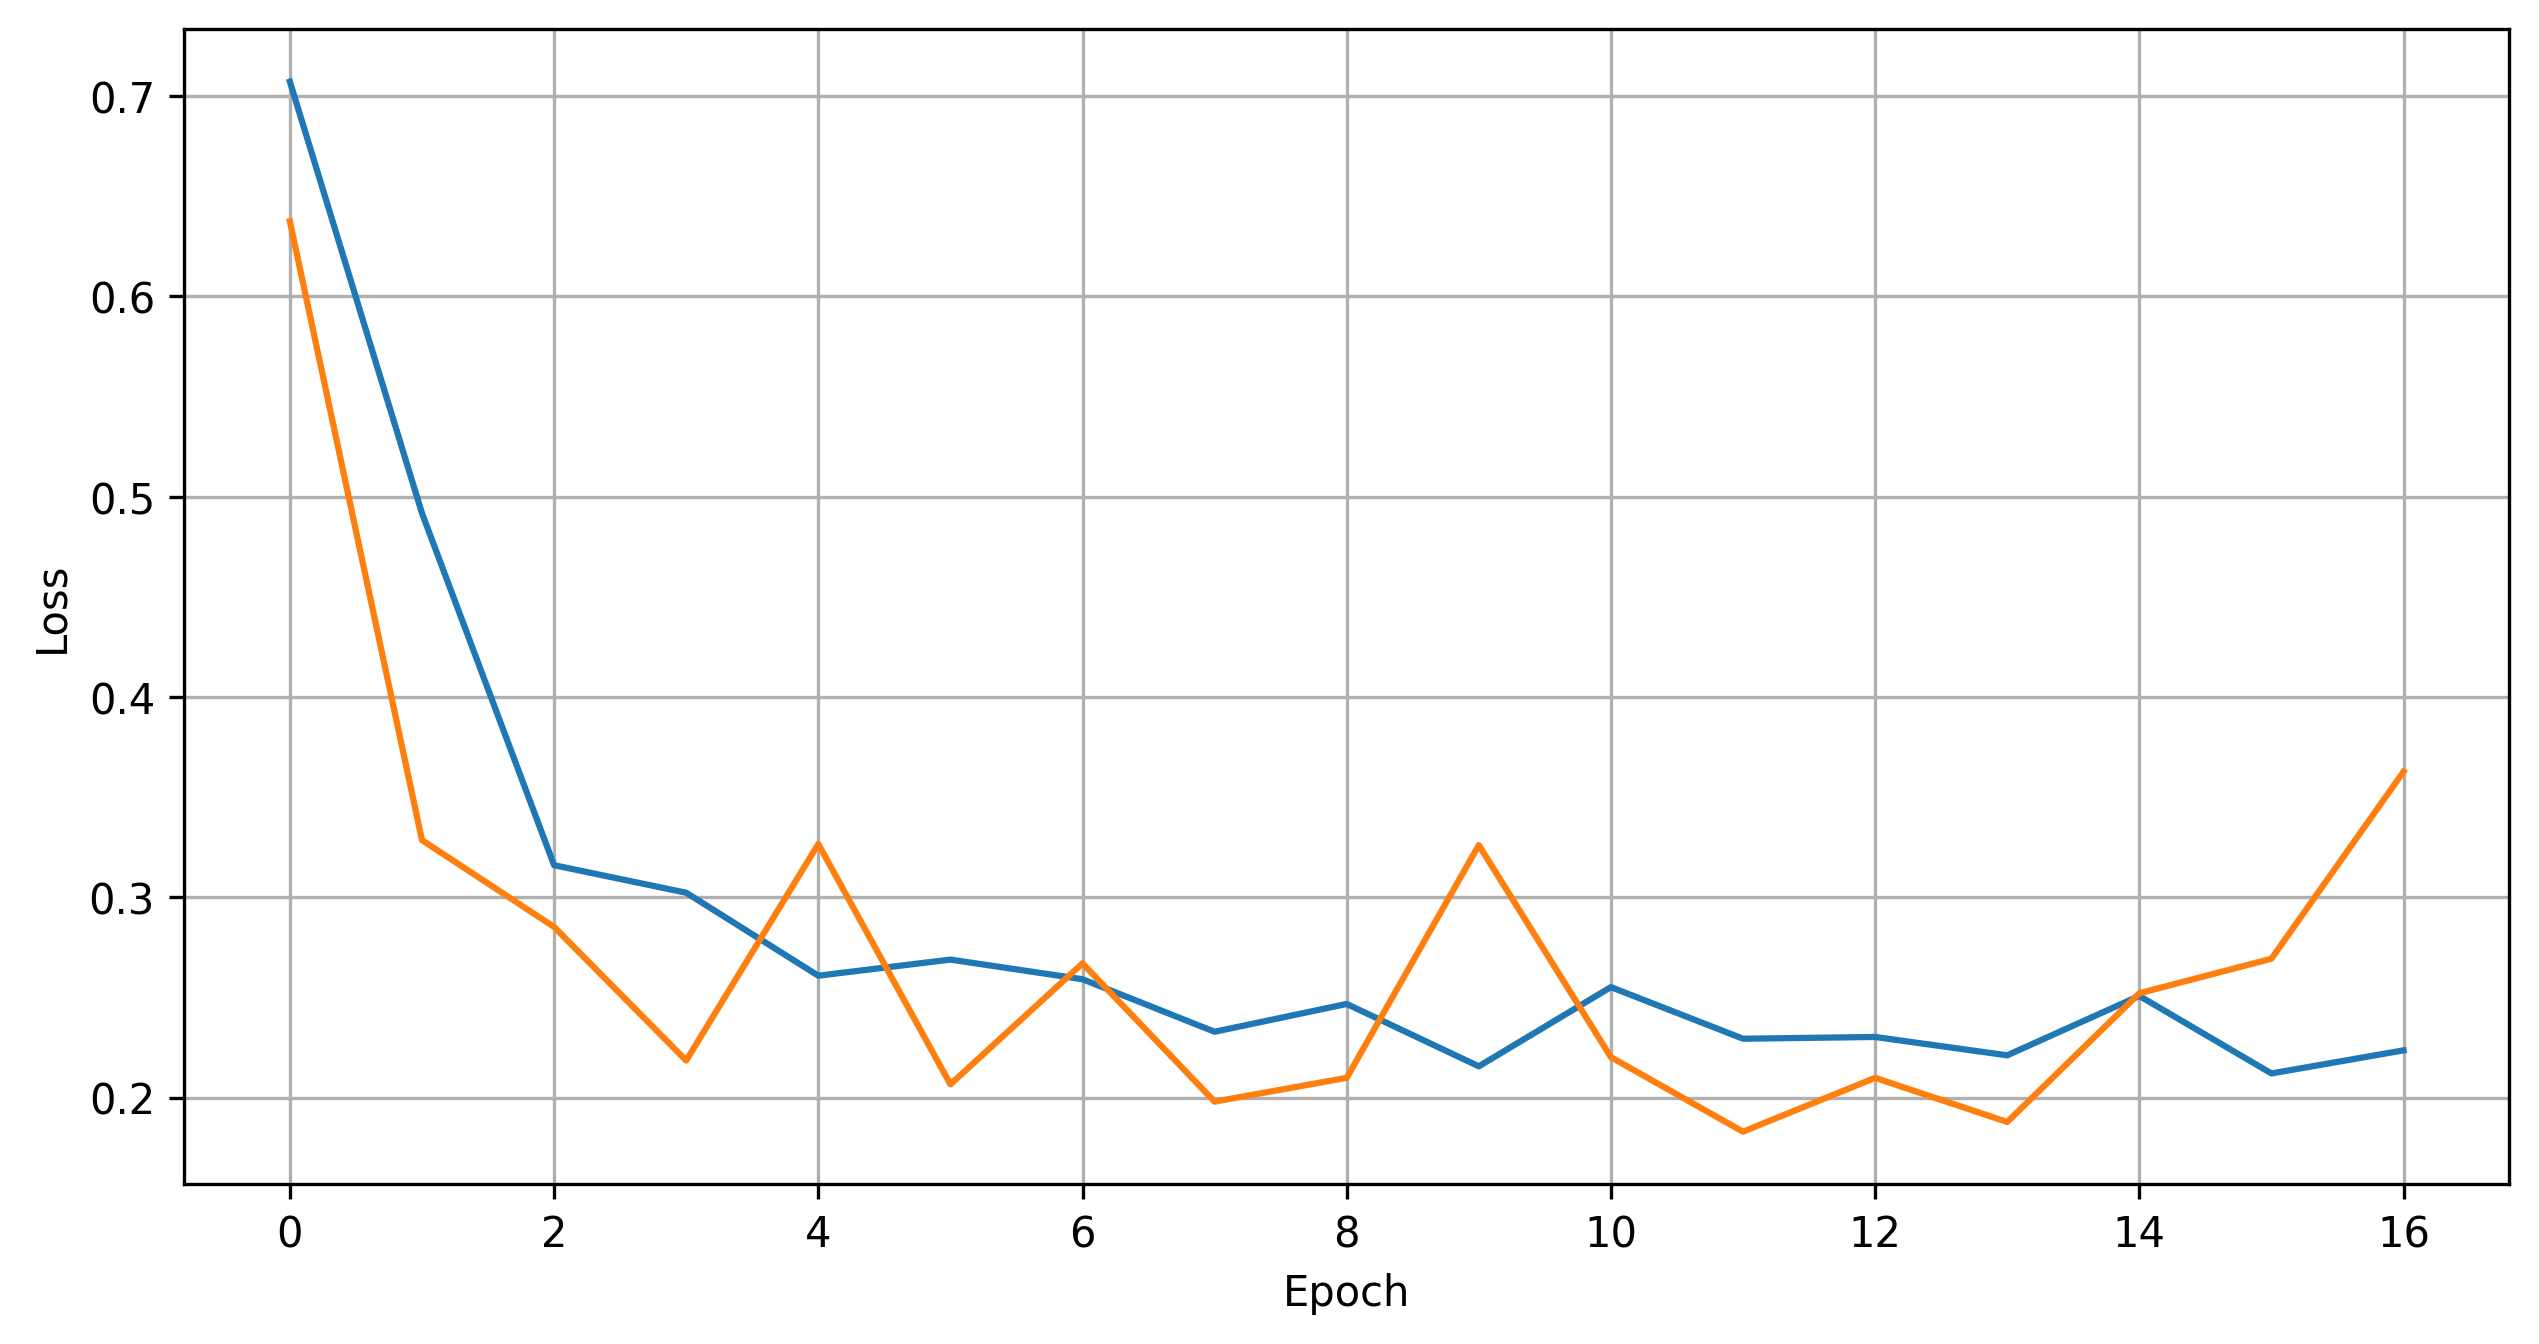

In [ ]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from scipy.signal import savgol_filter

Ttrain_A_data= np.array(History_acc_record)
Val_A_data= np.array(History_valacc_record)
Ttrain_L_data= np.array(History_loss_record)
Val_L_data= np.array(History_valloss_record)



X_data=np.stack((Ttrain_A_data,Val_A_data,Ttrain_L_data,Val_L_data),axis=2)

Y_data=np.array(equalization_record)
Y_data=Y_data.reshape(Y_data.shape[0],1)

#binarize Y_data if it is above 0.7 equal to 1, otherwise equal to 0
limiter=0.8
Y_data[Y_data>limiter]=1
Y_data[Y_data<=limiter]=0


#shuffel the data

X_data, Y_data = shuffle(X_data, Y_data, random_state=0)


input_length=X_data.shape[1]
num_channels=X_data.shape[2]


# Define input shape
input_shape = (input_length, num_channels)

# Define model
metric = Sequential()

# Add 1D Convolutional Layers
metric.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape))
metric.add(MaxPooling1D(pool_size=2))
# metric.add(layers.BatchNormalization())
metric.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
metric.add(MaxPooling1D(pool_size=2))
# metric.add(layers.BatchNormalization())
metric.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
metric.add(MaxPooling1D(pool_size=2))

metric.add(Flatten())

# Add fully connected layers for classification
metric.add(Dense(32, activation='relu'))
# metric.add(layers.Dropout(0.5))
metric.add(Dense(Y_data.shape[1], activation='sigmoid'))


# Compile the model
metric.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-2), loss='binary_crossentropy', metrics=['accuracy'])

#early stopping
es=tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=5)

# Fit the model
history_metric=metric.fit(X_data, Y_data, epochs=200, validation_split=0.1,batch_size=32, verbose=0,callbacks=[es])

# Plotting the accuracy and loss
plt.figure(figsize=(10, 5),dpi=300)
plt.plot(history_metric.history['accuracy'], label='accuracy')
plt.plot(history_metric.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()

plt.figure(figsize=(10, 5),dpi=300)
plt.plot(history_metric.history['loss'], label='loss')
plt.plot(history_metric.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()







In [ ]:
metric.evaluate(X_data,Y_data)

16/16 [==============================] - 0s 11ms/step - loss: 0.2747 - accuracy: 0.9152


[0.27471932768821716, 0.9151515364646912]

16/16 [==============================] - 0s 2ms/step


<AxesSubplot: >

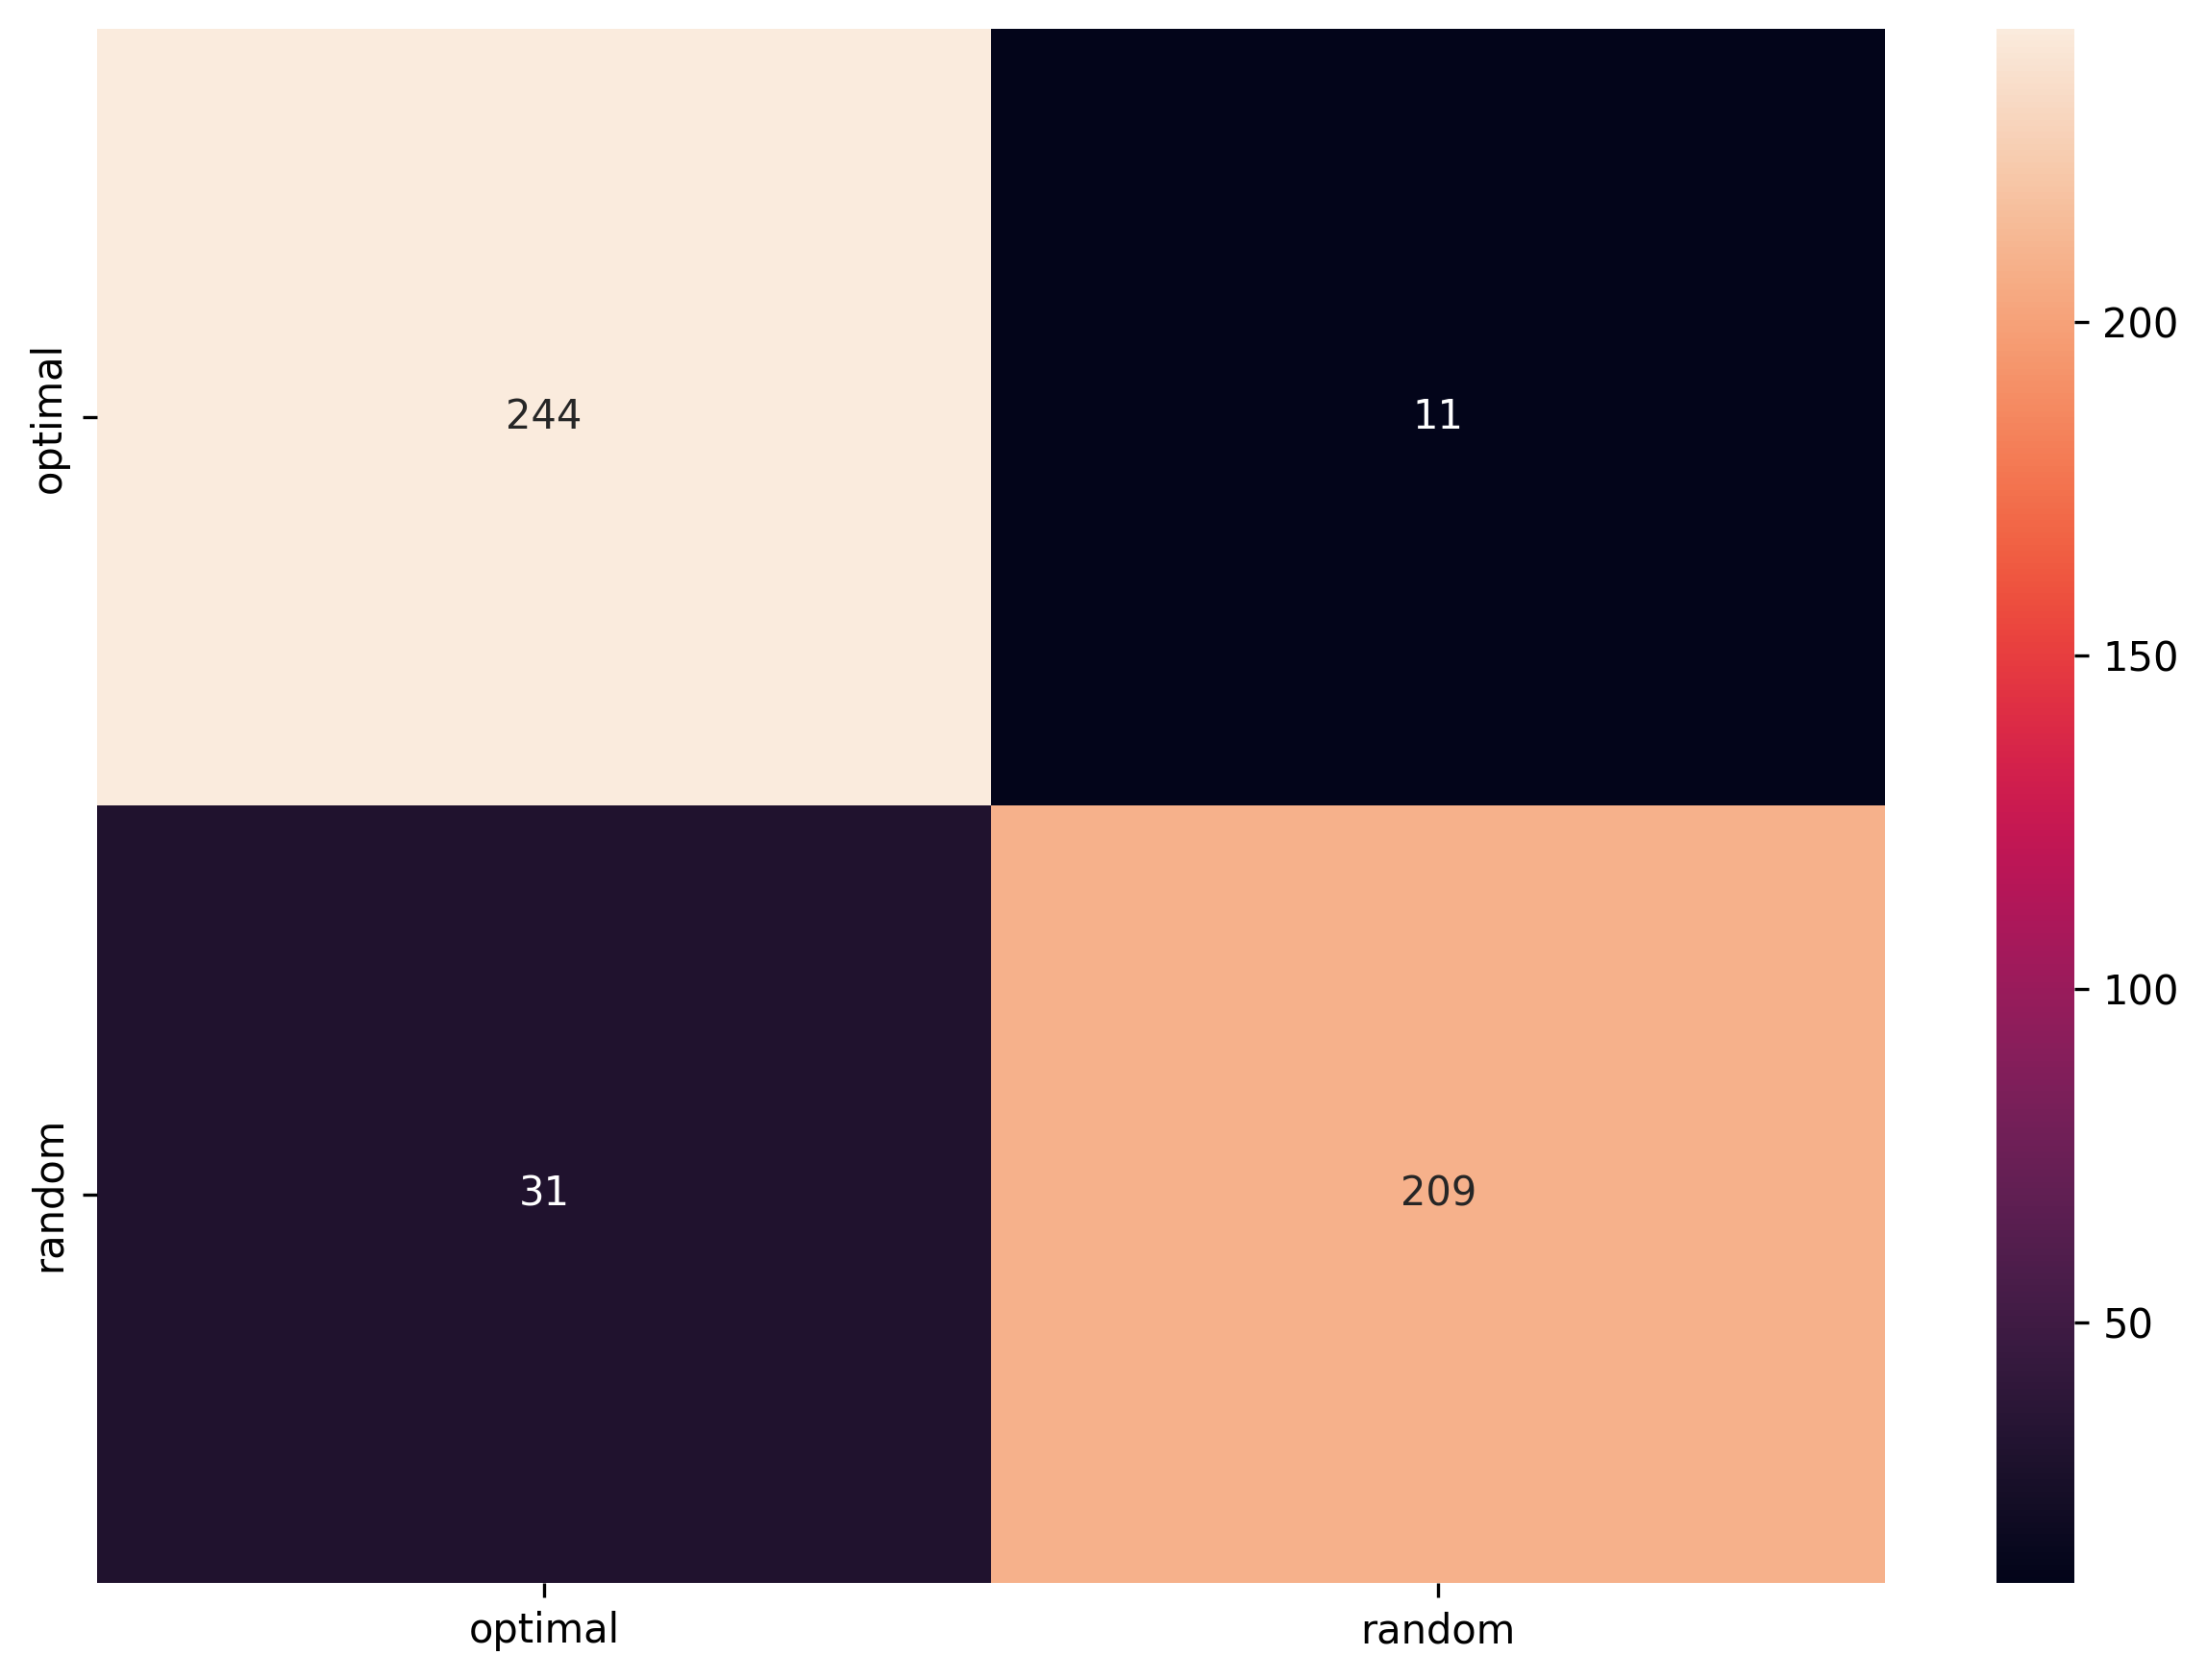

In [ ]:
#draw confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

y_pred = metric.predict(X_data)
y_pred = (y_pred > 0.8)
#add x- and y-label where 1 implies  optimal and random
cm = confusion_matrix(Y_data, y_pred)
df_cm = pd.DataFrame(cm, index = [i for i in ["optimal","random"]],
                    columns = [i for i in ["optimal","random"]])
plt.figure(figsize = (10,7),dpi=300)
sns.heatmap(df_cm, annot=True,fmt='g')


In [ ]:

record_matrices=[]
measurement_record=[]
trys=100

for trying in range(trys):
    # Get the shape of the destroyed kernel
    if trying<int(0.75*trys):

        ref_destroyed_kernel = np.copy(original_kernel)

        n = (4*trying+1)  # Number of entries to permute


        m=len(ref_destroyed_kernel) # Size of matrix

        #restrict n to be les than m**2
        if n>m**2:
            n=n%m**2

        # Flatten the matrix to a 1D array
        flat_matrix = ref_destroyed_kernel.flatten()

        # Randomly permute n elements in the flat matrix
        perm_indices = np.random.choice(m**2, size=n, replace=False)
        flat_matrix[perm_indices] = np.random.permutation(flat_matrix[perm_indices])

        # Reshape the flat matrix back to the original shape
        permuted_matrix = flat_matrix.reshape(m, m)

        destroyed_kernel_permuted= permuted_matrix 

        new_layer=layers.Conv2D(filters=1, kernel_size=kernel_sizer, strides=(1, 1),name='modified',
                            kernel_initializer=keras.initializers.Constant(value=destroyed_kernel_permuted),
                            trainable=False)

        prev_model=dummy_model

        #orchestrating a new model, same as dummy model, except its first convolution layer is replaced with permuted Arnold encrypted kernel layer
        inputs = layers.Input(shape=(img_size, img_size, 1),name='inner')
        x = inputs
        x= new_layer(x)
        for layer in prev_model.layers[1:]:
            x = prev_model.get_layer(layer.name)(x)
        #   print(layer.name, layer.trainable)

        mod_model=keras.Model(inputs, x)
        # Train the CNN
        mod_model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=1e-5),
            loss=keras.losses.CategoricalCrossentropy(from_logits=False),
            metrics=["accuracy"],
        )

        history=mod_model.fit(x_public, y_public, epochs=10, batch_size=64*2, validation_split=0.1,verbose=0)
        training_loss_mod=history.history['loss']
        val_loss_mod=history.history['val_loss']
        training_acc_mod=history.history['accuracy']
        val_acc_mod=history.history['val_accuracy']

        total_training_loss_mod=training_loss_dummy+training_loss_mod
        total_val_loss_mod=val_loss_dummy+val_loss_mod
        total_training_acc_mod=training_acc_dummy+training_acc_mod
        total_val_acc_mod=val_acc_dummy+val_acc_mod


        #stack A and L data to form dataset of sizetrys*10*2
        acc=np.array(total_training_acc_mod)
        loss=np.array(total_training_loss_mod)
        val_acc=np.array(total_val_acc_mod)
        val_loss=np.array(total_val_loss_mod)

        acc=np.expand_dims(acc,axis=0)
        loss=np.expand_dims(loss,axis=0)
        val_acc=np.expand_dims(val_acc,axis=0)
        val_loss=np.expand_dims(val_loss,axis=0)
        
        combo=np.stack((acc,loss,val_acc,val_loss),axis=2)
        indicator=metric.predict(combo,verbose=0)
        measure=indicator[0]
        record_matrices.append(destroyed_kernel_permuted)
        measurement_record.append(measure)

    else:
        m, n = destroyed_kernel.shape

        # Reshape the matrix into a 1D array
        matrix_1d = destroyed_kernel.reshape(-1)

        # Shuffle the 1D array randomly
        np.random.shuffle(matrix_1d)

        # Reshape the shuffled 1D array back to the original shape
        destroyed_kernel_permuted= matrix_1d.reshape(m, n)

        new_layer=layers.Conv2D(filters=1, kernel_size=kernel_sizer, strides=(1, 1),name='modified',
                            kernel_initializer=keras.initializers.Constant(value=destroyed_kernel_permuted),
                            trainable=False)

        prev_model=dummy_model

        #orchestrating a new model, same as dummy model, except its first convolution layer is replaced with permuted Arnold encrypted kernel layer
        inputs = layers.Input(shape=(img_size, img_size, 1),name='inner')
        x = inputs
        x= new_layer(x)
        for layer in prev_model.layers[1:]:
            x = prev_model.get_layer(layer.name)(x)
        #   print(layer.name, layer.trainable)

        mod_model=keras.Model(inputs, x)
        # Train the CNN
        mod_model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=1e-5),
            loss=keras.losses.CategoricalCrossentropy(from_logits=False),
            metrics=["accuracy"],
        )

        history=mod_model.fit(x_public, y_public, epochs=10, batch_size=64*2, validation_split=0.1,verbose=0)
        training_loss_mod=history.history['loss']
        val_loss_mod=history.history['val_loss']
        training_acc_mod=history.history['accuracy']
        val_acc_mod=history.history['val_accuracy']

        total_training_loss_mod=training_loss_dummy+training_loss_mod
        total_val_loss_mod=val_loss_dummy+val_loss_mod
        total_training_acc_mod=training_acc_dummy+training_acc_mod
        total_val_acc_mod=val_acc_dummy+val_acc_mod


        #stack A and L data to form dataset of sizetrys*10*2
        acc=np.array(total_training_acc_mod)
        loss=np.array(total_training_loss_mod)
        val_acc=np.array(total_val_acc_mod)
        val_loss=np.array(total_val_loss_mod)

        acc=np.expand_dims(acc,axis=0)
        loss=np.expand_dims(loss,axis=0)
        val_acc=np.expand_dims(val_acc,axis=0)
        val_loss=np.expand_dims(val_loss,axis=0)
        
        combo=np.stack((acc,loss,val_acc,val_loss),axis=2)
        indicator=metric.predict(combo,verbose=0)
        measure=indicator[0]
        record_matrices.append(destroyed_kernel_permuted)
        measurement_record.append(measure)





In [ ]:
def find_positions(lst, n):
    sorted_lst = sorted(lst, reverse=False)
    positions = []
    count = 0
    for i in range(len(lst)):
        if lst[i] in sorted_lst[:n]:
            positions.append(i)
            count += 1
            if count == n:
                break
    return positions

opti_index_list=find_positions(measurement_record,10)
for i in range(len(opti_index_list)):
    opti_index=opti_index_list[i]
    best_permuted_matrix=record_matrices[opti_index]
    same=count_equal(best_permuted_matrix,original_kernel)
    num_enteries=original_kernel.shape[0]*original_kernel.shape[1]
    record=same/num_enteries
    print("Probability of Match:  ",record)

Probability of Match:   0.18222222222222223
Probability of Match:   0.057777777777777775
Probability of Match:   0.013333333333333334
Probability of Match:   0.0044444444444444444
Probability of Match:   0.0044444444444444444
Probability of Match:   0.0044444444444444444
Probability of Match:   0.0044444444444444444
Probability of Match:   0.0044444444444444444
Probability of Match:   0.0044444444444444444
Probability of Match:   0.0044444444444444444


In [ ]:
opti_index=np.argmax(measurement_record)
best_permuted_matrix=record_matrices[opti_index]
same=count_equal(best_permuted_matrix,original_kernel)
num_enteries=original_kernel.shape[0]*original_kernel.shape[1]
record=same/num_enteries
print("Probability of Match:  ",record)

Probability of Match:   0.9911111111111112


In [ ]:
opti_index=np.argmin(measurement_record)
best_permuted_matrix=record_matrices[opti_index]
same=count_equal(best_permuted_matrix,original_kernel)
num_enteries=original_kernel.shape[0]*original_kernel.shape[1]
record=same/num_enteries
print("Minimum Probability of Match (Just to comfirm the faithfullness of proposed approach):  ",record)

Minimum Probability of Match (Just to comfirm the faithfullness of proposed approach):   0.0044444444444444444


Text(0.5, 1.0, 'Measurement Record')

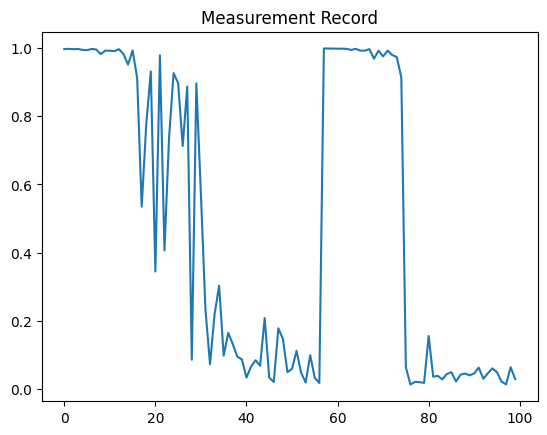

In [ ]:
plt.plot(measurement_record)
plt.title("Measurement Record")



Text(0.5, 1.0, 'Match Ratio Record')

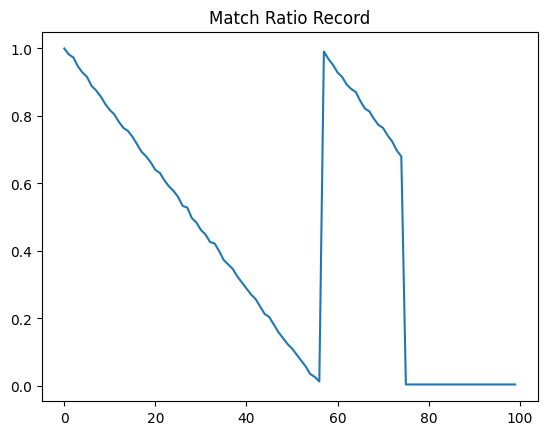

In [ ]:
match_record=[]
for i in range(len(record_matrices)):
    same=count_equal(record_matrices[i],original_kernel)
    num_enteries=original_kernel.shape[0]*original_kernel.shape[1]
    record=same/num_enteries
    match_record.append(record)

plt.plot(match_record)
plt.title("Match Ratio Record")

In [35]:
import numpy as np

def fitness_func(population, matrix):
    """
    This function calculates the fitness of each member in the population.
    The fitness is defined as the inverse of the difference between the product of the matrix
    and the population member and the identity matrix. The smaller the difference, the higher the fitness.
    """
    fitness = []
    for member in population:
        vec1=matrix.flatten()
        vec2=member.flatten()
        summer=0
        K=100
        for i in range(len(vec1)):
            for j in range(len(vec2)):
                summer+=np.exp(-K*(vec1[i]-vec2[j])**2)

        fitness_permutation=np.exp(-1*abs(summer-len(vec1)))

        #--------------------------------------------------------------------
        destroyed_kernel_permuted= np.copy(member)

        new_layer=layers.Conv2D(filters=1, kernel_size=kernel_sizer, strides=(1, 1),name='modified',
                            kernel_initializer=keras.initializers.Constant(value=destroyed_kernel_permuted),
                            trainable=False)

        prev_model=dummy_model

        #orchestrating a new model, same as dummy model, except its first convolution layer is replaced with permuted Arnold encrypted kernel layer
        inputs = layers.Input(shape=(img_size, img_size, 1),name='inner')
        x = inputs
        x= new_layer(x)
        for layer in prev_model.layers[1:]:
            x = prev_model.get_layer(layer.name)(x)

        mod_model=keras.Model(inputs, x)
        mod_model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=1e-5),
            loss=keras.losses.CategoricalCrossentropy(from_logits=False),
            metrics=["accuracy"],
        )

        history=mod_model.fit(x_public, y_public, epochs=10, batch_size=64*2, validation_split=0.1,verbose=0)
        training_loss_mod=history.history['loss']
        val_loss_mod=history.history['val_loss']
        training_acc_mod=history.history['accuracy']
        val_acc_mod=history.history['val_accuracy']

        total_training_loss_mod=training_loss_dummy+training_loss_mod
        total_val_loss_mod=val_loss_dummy+val_loss_mod
        total_training_acc_mod=training_acc_dummy+training_acc_mod
        total_val_acc_mod=val_acc_dummy+val_acc_mod


        #stack A and L data to form dataset of sizetrys*10*2
        acc=np.array(total_training_acc_mod)
        loss=np.array(total_training_loss_mod)
        val_acc=np.array(total_val_acc_mod)
        val_loss=np.array(total_val_loss_mod)

        acc=np.expand_dims(acc,axis=0)
        loss=np.expand_dims(loss,axis=0)
        val_acc=np.expand_dims(val_acc,axis=0)
        val_loss=np.expand_dims(val_loss,axis=0)
        
        combo=np.stack((acc,loss,val_acc,val_loss),axis=2)
        indicator=metric.predict(combo,verbose=0)
        fitness_measure=indicator[0,0]

        total_fitness=fitness_measure+fitness_permutation
        
        fitness.append(total_fitness)
    return fitness

def select_parents(population, fitness):
    """
    This function selects two parents from the population based on their fitness.
    The selection is done using the roulette wheel method.
    """
    total_fitness = np.sum(fitness)
    probabilities = fitness / total_fitness
    selected = np.random.choice(len(population), 2, p=probabilities)
    parents = [population[selected[0]], population[selected[1]]]
    return parents

def crossover(parents, prob):
    """
    This function performs a crossover operation on the two parents.
    The crossover is done by selecting a random index and swapping the elements from that index onwards.
    """
    child = np.zeros_like(parents[0])
    if np.random.random() < prob:
        index = np.random.randint(child.shape[0])
        child[:index] = parents[0][:index]
        child[index:] = parents[1][index:]
    else:
        child = parents[0]
    return child

def mutation(child, prob):
    """
    This function performs a mutation operation on the child.
    The mutation is done by selecting a random index and changing the value at that index to a random value.
    """
    if np.random.random() < prob:
        index = np.random.randint(child.shape[0])
        child[index] = np.random.uniform(-5, 5, size=child.shape[0])
    return child

def genetic_algorithm(matrix, pop_size=100, n_generations=10, prob_crossover=0.8, prob_mutation=0.1):
    """
    This function implements a simple genetic algorithm for finding a matrix that when multiplied
    with the input matrix gives the identity matrix.
    """
    # Initialize the population
    population = np.random.uniform(-5, 5, size=(pop_size, matrix.shape[0], matrix.shape[1]))
    best_fitness = 0
    best_individual = None

    # Evolve the population for n_generations
    for i in range(n_generations):
        # Calculate the fitness of each member in the population
        fitness = fitness_func(population, matrix)

        # Select the two best individuals as parents
        parents = select_parents(population, fitness)

        # Create a new child by performing crossover and mutation
        child = crossover(parents, prob_crossover)
        child = mutation(child, prob_mutation)

        # Replace the least fit individual in the population with the new child
        least_fit_index = np.argmin(fitness)
        population[least_fit_index] = child

        # Update the best fitness and best individual found so far
        if fitness[least_fit_index] > best_fitness:
            best_fitness = fitness[least_fit_index]
            best_individual = population[least_fit_index]

        # Print the best fitness every 100 generations
        if i % 1 == 0:
            print(f"Generation {i}: Best fitness = {best_fitness}")


    return best_individual


candidate_matrix=genetic_algorithm(destroyed_kernel)

#find permutation of destroyed_kernel, that is closest to candidate_matrix
vec_candidate=candidate_matrix.flatten()
vec_destroyed=destroyed_kernel.flatten()

filler_vec=np.zeros(vec_candidate.shape)

for i in range(len(vec_candidate)):
    errors=[]
    for j in range(len(vec_destroyed)):
        errors.append(abs(vec_candidate[i]-vec_destroyed[j]))

    min_indx=np.argmin(errors)
    filler_vec[i]=vec_destroyed[min_indx]

best_permuted_matrix=np.reshape(filler_vec,(kernel_sizer,kernel_sizer))

same=count_equal(best_permuted_matrix,original_kernel)
num_enteries=original_kernel.shape[0]*original_kernel.shape[1]
record=same/num_enteries
print("Probability of Match:  ",record)









Generation 0: Best fitness = 0.012571623548865318
Generation 1: Best fitness = 0.015829307958483696
Generation 2: Best fitness = 0.023117663338780403
Generation 3: Best fitness = 0.023117663338780403
Generation 4: Best fitness = 0.027535269036889076
Generation 5: Best fitness = 0.035131532698869705
Generation 6: Best fitness = 0.0502508208155632
Generation 7: Best fitness = 0.062300633639097214
Generation 8: Best fitness = 0.06542357057332993
Generation 9: Best fitness = 0.06542357057332993
Probability of Match:   0.0


Above code took 33 minutes for just 9 generations with zero percent match

 The best solution found:                                                                           
 [-9.23309944 -6.14728603  9.79790952 -7.66444518  1.29765471 -4.97483796
  0.4362902  -0.21947989  6.39483901 -4.9394676  -0.36514747  3.85949489
  9.57908377 -4.81571902 -1.03116163 -3.7866823  -5.14006673  1.41190609
 -8.51558544 -2.59042234  9.48580979 -2.981117   -2.31827954 -8.590595
  5.00008417 -3.13131192 -2.63042987  5.89294652  6.70336869  2.73832499
 -6.62568086 -9.94663088  1.27974741 -5.03265618  3.92339225 -3.74606072
 -0.32628727  9.56443878  7.8186811  -6.75826007 -7.97395719  4.59019724
  2.59494214  3.91723616 -0.21489285 -5.85970936 -2.48411927  2.96055888
  7.28297005  9.8610651   2.33544319 -6.22772388  1.43049492  0.17041047
  0.78949266 -2.58437849  5.45318028  7.29907284  6.47713918  5.28802618
 -1.62250048 -4.4593753   9.46316165 -2.94291558 -9.33286639 -3.74072422
 -1.53752419  3.56200484  5.47547799  2.91122608  0.65618043  1.23138952
  3.96401308  5.75092469

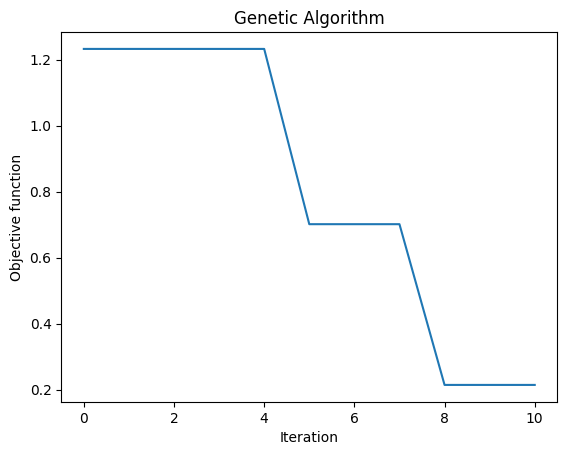

In [44]:
import numpy as np
from geneticalgorithm import geneticalgorithm as ga


important_given_kernel=np.copy(destroyed_kernel)
important_given_kernel_vec=important_given_kernel.flatten()


def f(X):
    vec1=important_given_kernel_vec
    vec2=X
    summer=0
    K=100
    for i in range(len(vec1)):
        for j in range(len(vec2)):
            summer+=np.exp(-K*(vec1[i]-vec2[j])**2)

    fitness_permutation=np.exp(-1*abs(summer-len(vec1)))
    loss_permutation=abs(summer-len(vec1))

    #--------------------------------------------------------------------
    destroyed_kernel_permuted= np.reshape(X,(kernel_sizer,kernel_sizer))

    new_layer=layers.Conv2D(filters=1, kernel_size=kernel_sizer, strides=(1, 1),name='modified',
                        kernel_initializer=keras.initializers.Constant(value=destroyed_kernel_permuted),
                        trainable=False)

    prev_model=dummy_model

    #orchestrating a new model, same as dummy model, except its first convolution layer is replaced with permuted Arnold encrypted kernel layer
    inputs = layers.Input(shape=(img_size, img_size, 1),name='inner')
    x = inputs
    x= new_layer(x)
    for layer in prev_model.layers[1:]:
        x = prev_model.get_layer(layer.name)(x)

    mod_model=keras.Model(inputs, x)
    mod_model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-5),
        loss=keras.losses.CategoricalCrossentropy(from_logits=False),
        metrics=["accuracy"],
    )

    history=mod_model.fit(x_public, y_public, epochs=10, batch_size=64*2, validation_split=0.1,verbose=0)
    training_loss_mod=history.history['loss']
    val_loss_mod=history.history['val_loss']
    training_acc_mod=history.history['accuracy']
    val_acc_mod=history.history['val_accuracy']

    total_training_loss_mod=training_loss_dummy+training_loss_mod
    total_val_loss_mod=val_loss_dummy+val_loss_mod
    total_training_acc_mod=training_acc_dummy+training_acc_mod
    total_val_acc_mod=val_acc_dummy+val_acc_mod


    #stack A and L data to form dataset of sizetrys*10*2
    acc=np.array(total_training_acc_mod)
    loss=np.array(total_training_loss_mod)
    val_acc=np.array(total_val_acc_mod)
    val_loss=np.array(total_val_loss_mod)

    acc=np.expand_dims(acc,axis=0)
    loss=np.expand_dims(loss,axis=0)
    val_acc=np.expand_dims(val_acc,axis=0)
    val_loss=np.expand_dims(val_loss,axis=0)
    
    combo=np.stack((acc,loss,val_acc,val_loss),axis=2)
    indicator=metric.predict(combo,verbose=0)
    fitness_measure=indicator[0,0]
    loss_measure=1-fitness_measure

    total_fitness=fitness_measure+fitness_permutation
    total_loss=loss_measure+loss_permutation
    return total_loss



varbound=np.array([[-10,10]]*kernel_sizer*kernel_sizer)

algorithm_param = {'max_num_iteration': 10,\
                   'population_size':100,\
                   'mutation_probability':0.1,\
                   'elit_ratio': 0.01,\
                   'crossover_probability': 0.5,\
                   'parents_portion': 0.3,\
                   'crossover_type':'uniform',\
                   'max_iteration_without_improv':None}

ga_model=ga(function=f,dimension=kernel_sizer*kernel_sizer,variable_type='real',variable_boundaries=varbound,algorithm_parameters=algorithm_param)

ga_model.run()

The above code took 36 minutes

In [48]:
convergence=ga_model.report
best_solution=ga_model.output_dict

In [72]:
best_sol=best_solution['variable']
pseudo_kernel=best_sol.reshape((kernel_sizer,kernel_sizer))

destroyed_kernel_flattened=destroyed_kernel.flatten()

filler_vec=np.zeros(best_sol.shape)

for i in range(len(best_sol)):
    errors=[]
    for j in range(len(destroyed_kernel_flattened)):
        errors.append(abs(best_sol[i]-destroyed_kernel_flattened[j]))

    #find index of second smallest error
    min_index = errors.index(min(errors))
    filler_vec[i]=destroyed_kernel_flattened[min_indx]

best_permuted_matrix=np.reshape(filler_vec,(kernel_sizer,kernel_sizer))

same=count_equal(best_permuted_matrix,original_kernel)
num_enteries=original_kernel.shape[0]*original_kernel.shape[1]
record=same/num_enteries
print("Probability of Match (GA-Convex):  ",record)



Probability of Match (GA-Convex):   0.0044444444444444444


In [63]:
opti_index=np.argmax(measurement_record)
bruteforced_kernel=record_matrices[opti_index]
same=count_equal(bruteforced_kernel,original_kernel)
num_enteries=original_kernel.shape[0]*original_kernel.shape[1]
record=same/num_enteries
print("Probability of Match (Bruteforce):  ",record)

Probability of Match:   0.9911111111111112


Text(0.5, 1.0, 'Destroyed Result')

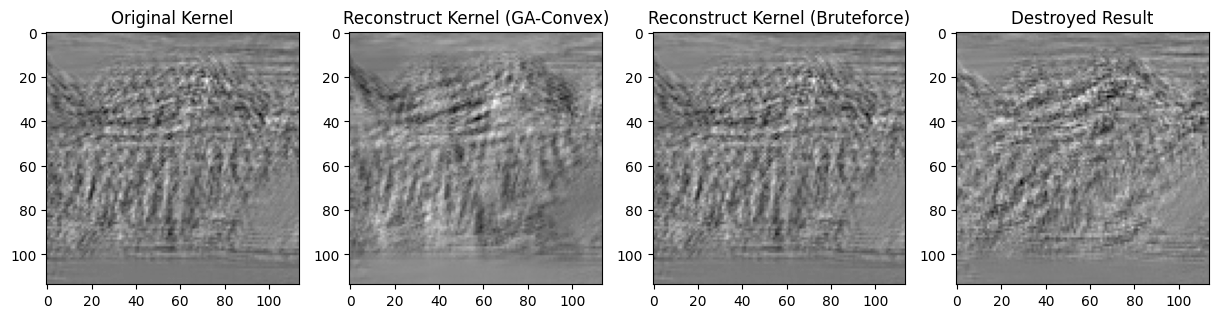

In [68]:
result_ref=convolve2D(image, original_kernel)
result_reconstructed=convolve2D(image, pseudo_kernel)
result_reconstructed_bruteforce=convolve2D(image, bruteforced_kernel)


#comparing the results
plt.figure(figsize=(15,10))
plt.subplot(1,4,1)
plt.imshow(result_ref,cmap='gray')
plt.title("Original Kernel")
plt.subplot(1,4,2)
plt.imshow(result_reconstructed,cmap='gray')
plt.title("Reconstruct Kernel (GA-Convex)")

plt.subplot(1,4,3)
plt.imshow(result_reconstructed_bruteforce,cmap='gray')
plt.title("Reconstruct Kernel (Bruteforce)")

plt.subplot(1,4,4)
plt.imshow(destroyed_result,cmap='gray')
plt.title("Destroyed Result")

